# Machine Learning (ML): Google Cloud Platform (GCP): TensorFlow (TF): Financial Time-Series
# Model 01 = Binary Classifier
# Model 02 = Neural Network

## 1) Import Libraries

In [14]:
import StringIO

import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import scatter_matrix

import numpy as np

import matplotlib.pyplot as plt

import gcp
import gcp.bigquery as bq

import tensorflow as tf

from IPython.core.display import HTML


## 2) Install stuff

In [2]:
# Install xlrd - required for reading excel files
# !pip install xlrd
!pip install xlrd
# -----------------------------------------------------------------------------------------------
# Downloading/unpacking xlrd
#   Downloading xlrd-1.0.0.tar.gz (2.6MB): 2.6MB downloaded
#   Running setup.py (path:/tmp/pip-build-brL6Op/xlrd/setup.py) egg_info for package xlrd
    
#     warning: no files found matching 'README.html'
# Installing collected packages: xlrd
#   Running setup.py install for xlrd
#     changing mode of build/scripts-2.7/runxlrd.py from 644 to 755
    
#     warning: no files found matching 'README.html'
#     changing mode of /usr/local/bin/runxlrd.py to 755
#   Could not find .egg-info directory in install record for xlrd
# Successfully installed xlrd
# Cleaning up...
# -----------------------------------------------------------------------------------------------


Downloading/unpacking xlrd
  Running setup.py (path:/tmp/pip-build-I4_wQa/xlrd/setup.py) egg_info for package xlrd
    
  Running setup.py install for xlrd
    changing mode of build/scripts-2.7/runxlrd.py from 644 to 755
    
    changing mode of /usr/local/bin/runxlrd.py to 755
  Could not find .egg-info directory in install record for xlrd
Cleaning up...


In [3]:
# Install dropbox - required for writing files to dropbox, not required for reading files from dropbox
!pip install dropbox
# -----------------------------------------------------------------------------------------------
# Downloading/unpacking dropbox
#   Downloading dropbox-6.6.2-py2-none-any.whl (261kB): 261kB downloaded
# Requirement already satisfied (use --upgrade to upgrade): six>=1.3.0 in /usr/local/lib/python2.7/dist-packages (from dropbox)
# Requirement already satisfied (use --upgrade to upgrade): urllib3 in /usr/lib/python2.7/dist-packages (from dropbox)
# Downloading/unpacking requests!=2.6.1,>=2.5.1 (from dropbox)
#   Downloading requests-2.11.0-py2.py3-none-any.whl (514kB): 514kB downloaded
# Downloading/unpacking typing>=3.5.2 (from dropbox)
#   Downloading typing-3.5.2.2.tar.gz (51kB): 51kB downloaded
#   Running setup.py (path:/tmp/pip-build-xSBpJ2/typing/setup.py) egg_info for package typing
    
# Installing collected packages: dropbox, requests, typing
#   Found existing installation: requests 2.4.3
#     Not uninstalling requests at /usr/lib/python2.7/dist-packages, owned by OS
#   Running setup.py install for typing
    
#   Could not find .egg-info directory in install record for typing>=3.5.2 (from dropbox)
# Successfully installed dropbox requests typing
# Cleaning up...
# -----------------------------------------------------------------------------------------------


Downloading/unpacking dropbox
Downloading/unpacking typing>=3.5.2 (from dropbox)
  Running setup.py (path:/tmp/pip-build-l1IAqm/typing/setup.py) egg_info for package typing
    
Downloading/unpacking requests!=2.6.1,>=2.5.1 (from dropbox)
  Running setup.py install for typing
    
  Could not find .egg-info directory in install record for typing>=3.5.2 (from dropbox)
  Found existing installation: requests 2.4.3
    Not uninstalling requests at /usr/lib/python2.7/dist-packages, owned by OS
Cleaning up...


## 3) Data File: From dropbox to GCP

In [41]:
# Save file on dropbox, and put the URL here
s_data_dropbox_file_path_name_ext = 'https://www.dropbox.com/s/foso5ckzl9vrui0/fx_mxn_data_raw.xlsm'
print '* s_data_dropbox_file_path_name_ext = ' + s_data_dropbox_file_path_name_ext

# Store file name meta data
import os
s_data_dropbox_file_path_name, s_dropbox_data_file_ext = os.path.splitext(s_dropbox_data_file_path_name_ext)
s_data_dropbox_file_path, s_data_file_name = os.path.split(s_dropbox_data_file_path_name)
print '  * s_dropbox_data_file_path_name = ' + s_dropbox_data_file_path_name
print '  * s_dropbox_data_file_path      = ' + s_dropbox_data_file_path
print '  * s_dropbox_data_file_name      = ' + s_dropbox_data_file_name
print '  * s_dropbox_data_file_ext       = ' + s_dropbox_data_file_ext

# Select force = 0 or 1
# force = 0 => Just use existing data on GCP
# force = 1 => Always grab from dropbox and copy to GCP, overwriting exisiting if any.
force = 1
print '* force = ' + str(force)

# # Import file using url to file on dropbox
from urlparse import urlparse
from os.path import basename

s_google_data_file_path_name_ext = basename(urlparse(s_dropbox_data_file_path_name_ext).path)
fx_mxn_bn_data_raw = basename(urlparse(s_dropbox_data_file_path_name_ext).path)
print '* s_google_data_file_path_name_ext = ' + s_google_data_file_path_name_ext

print '===== Display Current Directory ========================================'
!ls -l  

print '===== Check if file exists on GCP ============================================='
try:
    already_downloaded
except:
    already_downloaded = False
print '* already_downloaded = ' + str(already_downloaded)
    
if not already_downloaded or force:    
    print '===== Delete the current data file on GCP ============================================='
    !rm $s_google_data_file_path_name_ext    # Delete the current data file on GCP
    print '===== Get latest data file from dropbox to GCP ========================================'
    !wget $s_data_file_path_name_ext # Get latest data file from dropbox to GCP
    already_downloaded = True
    
print '===== Display Current Directory ========================================'
!ls -l  
    

* s_data_file_path_name_ext = https://www.dropbox.com/s/foso5ckzl9vrui0/fx_mxn_data_raw.xlsm
  * s_data_file_path_name = https://www.dropbox.com/s/foso5ckzl9vrui0/fx_mxn_data_raw
  * s_data_file_path = https://www.dropbox.com/s/foso5ckzl9vrui0
  * s_data_file_name = fx_mxn_data_raw
  * s_data_file_ext = .xlsm
* force = 1
* fx_mxn_bn_data_raw = fx_mxn_data_raw.xlsm
===== Display Current Directory ========================================
total 6656
-rw-r--r-- 1 root root 4001691 Aug 29 02:40 ML__GCP_TF__BC_NN__MXN.ipynb
drwxr-xr-x 5 root root    4096 Aug 26 21:27 datalab
-rw-r--r-- 1 root root 2807130 Aug 29 02:41 fx_mxn_data_raw.xlsm
===== Check if file exists on GCP =============================================
* already_downloaded = True
===== Delete the current data file on GCP =============================================
===== Get latest data file from dropbox to GCP ========================================
converted 'https://www.dropbox.com/s/foso5ckzl9vrui0/fx_mxn_data_raw.xlsm' 

## 4) Read the Excel file raw data

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xlrd

# Read the excel data that is on GCP
fx_mxn_df_data_raw = pd.read_excel(fx_mxn_bn_data_raw, 'data_raw')
# data = pd.read_excel(bn_data_raw, 'data_raw', header=0, index_col=0, parse_cols=None)
  # parse_cols=None: parse all columns
  # header=0:    sets the row 0 as col labels (ie. headers)
  # index_col=0: sets the col 0 as row labels (ie. index)
fx_mxn_df_data_raw.head() # display the first few lines

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,Ticker,USDMXN Curncy,ASURB MM Equity,BIMBOA MM Equity,CN1 Comdty,CT350188 Curncy,DU1 Comdty,ED749713@BVAL Corp,EMRUEMRU Index,EURMXN3Y Curncy,...,USSA25 ICPL Curncy,USSA30 ICPL Curncy,USSP15 CMPN Curncy,USSP20 CMPN Curncy,USSP25 CMPN Curncy,USSW15 CMPN Curncy,USSW20 CMPN Curncy,USSW25 CMPN Curncy,USSW30 CMPN Curncy,XQ1 Comdty
1,Date,USDMXN Curncy,ASURB MM Equity,BIMBOA MM Equity,CN1 Comdty,CT350188 Curncy,DU1 Comdty,ED749713@BVAL Corp,EMRUEMRU Index,EURMXN3Y Curncy,...,USSA25 ICPL Curncy,USSA30 ICPL Curncy,USSP15 CMPN Curncy,USSP20 CMPN Curncy,USSP25 CMPN Curncy,USSW15 CMPN Curncy,USSW20 CMPN Curncy,USSW25 CMPN Curncy,USSW30 CMPN Curncy,XQ1 Comdty
2,2016-05-27 00:00:00,18.4751,289.95,55.4,141.28,424.14,111.85,118.813,66.0342,35645.2,...,2.102,2.138,-10.63,-18,-31.63,1.943,2.074,2.133,2.1738,124.13
3,2016-05-26 00:00:00,18.4544,284.68,55.29,141.83,427.999,111.845,118.75,65.282,35316.9,...,2.104,2.139,-10.46,-17.65,-31.43,1.928,2.0575,2.125,2.1598,124.3
4,2016-05-25 00:00:00,18.4852,281.4,56.33,140.98,5392.86,111.825,118.438,65.9242,35680.2,...,2.107,2.14,-11.11,-18.4,-32.03,1.955,2.0825,2.1453,2.1785,124.11


In [25]:
fx_mxn_df_data_raw.tail() 

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
4277,2000-01-07 00:00:00,9.565,14.23,4.83,117.45,382.997,102.71,132.35,27.321,22485,...,7.475,7.465,87,89,84,7.39,7.41,6.461,7.4,98
4278,2000-01-06 00:00:00,9.58,14.23,4.68,117.09,382.997,102.5,132.35,27.321,22485,...,7.505,7.48,89,90,84,7.43,7.44,6.461,7.43,97.7
4279,2000-01-05 00:00:00,9.571,14.23,4.83,116.57,382.997,102.49,132.35,27.321,22485,...,7.475,7.455,88,89,84,7.47,7.48,6.461,7.46,97.55
4280,2000-01-04 00:00:00,9.5713,14.23,4.83,117.5,382.997,102.49,132.35,27.54,22485,...,7.425,7.425,90,91,84,7.4,7.41,6.461,7.4,98
4281,2000-01-03 00:00:00,9.505,14.23,5.03,118.5,382.997,102.47,132.35,27.54,22485,...,7.455,7.425,86,87,84,7.46,7.47,6.461,7.44,98.56


## Store the number of columns

In [26]:
type(fx_mxn_df_data_raw)

pandas.core.frame.DataFrame

In [28]:
[fx_mxn_num_rows, fx_mxn_num_cols] = fx_mxn_df_data_raw.shape
print 'fx_mxn_num_rows='+str(fx_mxn_num_rows)
print 'fx_mxn_num_cols='+str(fx_mxn_num_cols)

fx_mxn_num_cols_Date = 1
fx_mxn_num_cols_XTp0 = 1
fx_mxn_num_cols_var = fx_mxn_num_cols - fx_mxn_num_cols_Date - fx_mxn_num_cols_XTp0
print 'fx_mxn_num_cols_Date = '+str(fx_mxn_num_cols_Date)
print 'fx_mxn_num_cols_XTp0 = '+str(fx_mxn_num_cols_XTp0)
print 'fx_mxn_num_cols_var = '+str(fx_mxn_num_cols_var)


fx_mxn_num_rows=4282
fx_mxn_num_cols=87
fx_mxn_num_cols_Date = 1
fx_mxn_num_cols_XTp0 = 1
fx_mxn_num_cols_var = 85


In [33]:
s_rows = '{0:05d}'.format(fx_mxn_num_rows)
s_rows
s_cols = '{0:05d}'.format(fx_mxn_num_cols)
s_cols


'00087'

## 4.1) Write the Excel file back to dropbox

In [29]:
# Include the Dropbox SDK
import dropbox

In [34]:
s_dropbox_access_token = 'Z0hHmWIPD4AAAAAAAAAADKBYofFVGTUnVcva8HKUpKCj6SDaY15WNHIZcRcEknoO'
client = dropbox.client.DropboxClient(s_dropbox_access_token)
print 'linked account: ', client.account_info()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: DeprecationWarning: You are using a deprecated client. Please use the new v2 client located at dropbox.Dropbox.
  from ipykernel import kernelapp as app


linked account:  {u'referral_link': u'https://db.tt/wTxYqge4', u'display_name': u'Eyup Saltik', u'uid': 576395988, u'locale': u'en', u'email_verified': True, u'email': u'eyup.saltik.2016@gmail.com', u'is_paired': False, u'team': None, u'name_details': {u'familiar_name': u'Eyup', u'surname': u'Saltik', u'given_name': u'Eyup'}, u'country': u'SG', u'quota_info': {u'datastores': 0, u'shared': 0, u'quota': 2147483648, u'normal': 54231633}}


In [20]:
response = client.put_file('/fx_mxn_data_raw_from_GCP.csv', str(fx_mxn_df_data_raw.to_csv()), overwrite=True)
print "uploaded:", response

uploaded: {u'icon': u'page_white_excel', u'bytes': 2706031, u'thumb_exists': False, u'rev': u'464a1e9d47', u'modified': u'Tue, 23 Aug 2016 08:24:22 +0000', u'shareable': False, u'client_mtime': u'Tue, 23 Aug 2016 08:24:22 +0000', u'path': u'/fx_mxn_data_raw_from_GCP.csv', u'is_dir': False, u'size': u'2.6 MB', u'root': u'dropbox', u'mime_type': u'text/csv', u'revision': 70}


## 5) Select data df

In [21]:
df = fx_mxn_df_data_raw
df.head()

,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
0,Ticker,USDMXN Curncy_Tp1,USDMXN Curncy,ASURB MM Equity,BIMBOA MM Equity,CN1 Comdty,CT350188 Curncy,DU1 Comdty,ED749713@BVAL Corp,EMRUEMRU Index,...,USSA25 ICPL Curncy,USSA30 ICPL Curncy,USSP15 CMPN Curncy,USSP20 CMPN Curncy,USSP25 CMPN Curncy,USSW15 CMPN Curncy,USSW20 CMPN Curncy,USSW25 CMPN Curncy,USSW30 CMPN Curncy,XQ1 Comdty
1,Date,USDMXN Curncy_Tp1,USDMXN Curncy,ASURB MM Equity,BIMBOA MM Equity,CN1 Comdty,CT350188 Curncy,DU1 Comdty,ED749713@BVAL Corp,EMRUEMRU Index,...,USSA25 ICPL Curncy,USSA30 ICPL Curncy,USSP15 CMPN Curncy,USSP20 CMPN Curncy,USSP25 CMPN Curncy,USSW15 CMPN Curncy,USSW20 CMPN Curncy,USSW25 CMPN Curncy,USSW30 CMPN Curncy,XQ1 Comdty
2,2016-05-27 00:00:00,18.4855,18.4751,289.95,55.4,141.28,424.14,111.85,118.813,66.0342,...,2.102,2.138,-10.63,-18,-31.63,1.943,2.074,2.133,2.1738,124.13
3,2016-05-26 00:00:00,18.4751,18.4544,284.68,55.29,141.83,427.999,111.845,118.75,65.282,...,2.104,2.139,-10.46,-17.65,-31.43,1.928,2.0575,2.125,2.1598,124.3
4,2016-05-25 00:00:00,18.4544,18.4852,281.4,56.33,140.98,5392.86,111.825,118.438,65.9242,...,2.107,2.14,-11.11,-18.4,-32.03,1.955,2.0825,2.1453,2.1785,124.11


## 6) df_ticker_desc = Just a table to map column id to the ticker and name of the variable

In [22]:
df_ticker_desc = df.ix[:1] # 1st 2 rows
df_ticker_desc

,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
0,Ticker,USDMXN Curncy_Tp1,USDMXN Curncy,ASURB MM Equity,BIMBOA MM Equity,CN1 Comdty,CT350188 Curncy,DU1 Comdty,ED749713@BVAL Corp,EMRUEMRU Index,...,USSA25 ICPL Curncy,USSA30 ICPL Curncy,USSP15 CMPN Curncy,USSP20 CMPN Curncy,USSP25 CMPN Curncy,USSW15 CMPN Curncy,USSW20 CMPN Curncy,USSW25 CMPN Curncy,USSW30 CMPN Curncy,XQ1 Comdty
1,Date,USDMXN Curncy_Tp1,USDMXN Curncy,ASURB MM Equity,BIMBOA MM Equity,CN1 Comdty,CT350188 Curncy,DU1 Comdty,ED749713@BVAL Corp,EMRUEMRU Index,...,USSA25 ICPL Curncy,USSA30 ICPL Curncy,USSP15 CMPN Curncy,USSP20 CMPN Curncy,USSP25 CMPN Curncy,USSW15 CMPN Curncy,USSW20 CMPN Curncy,USSW25 CMPN Curncy,USSW30 CMPN Curncy,XQ1 Comdty


## 7) df_values(0:87) = date(0) + col(1) + col(2) + col(3:87)

In [23]:
df_values = df.ix[2:] # row 2 onwards
df_values.head()

,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
2,2016-05-27 00:00:00,18.4855,18.4751,289.95,55.4,141.28,424.14,111.85,118.813,66.0342,...,2.102,2.138,-10.63,-18,-31.63,1.943,2.074,2.133,2.1738,124.13
3,2016-05-26 00:00:00,18.4751,18.4544,284.68,55.29,141.83,427.999,111.845,118.75,65.282,...,2.104,2.139,-10.46,-17.65,-31.43,1.928,2.0575,2.125,2.1598,124.3
4,2016-05-25 00:00:00,18.4544,18.4852,281.4,56.33,140.98,5392.86,111.825,118.438,65.9242,...,2.107,2.14,-11.11,-18.4,-32.03,1.955,2.0825,2.1453,2.1785,124.11
5,2016-05-24 00:00:00,18.4852,18.487,282.81,56.06,141.16,5392.86,111.815,118.5,66.8658,...,2.126,2.158,-11.18,-18.43,-31.94,1.9469,2.0703,2.1305,2.1615,124.24
6,2016-05-23 00:00:00,18.487,18.5161,282.02,55.27,141.31,5392.86,111.815,120.188,67.0104,...,2.092,2.125,-10.81,-18.14,-31.55,1.9245,2.0503,2.112,2.1435,124.27


## 8) Set the dates as index of the dataframe = 2000-01-03 to 2016-05-27 

In [24]:
df_values_indexed = df_values.set_index([0])
df_values_indexed.head()

,1,2,3,4,5,6,7,8,9,10,...,78,79,80,81,82,83,84,85,86,87
0,,,,,,,,,,,,,,,,,,,,,
2016-05-27,18.4855,18.4751,289.95,55.4,141.28,424.14,111.85,118.813,66.0342,35645.2,...,2.102,2.138,-10.63,-18,-31.63,1.943,2.074,2.133,2.1738,124.13
2016-05-26,18.4751,18.4544,284.68,55.29,141.83,427.999,111.845,118.75,65.282,35316.9,...,2.104,2.139,-10.46,-17.65,-31.43,1.928,2.0575,2.125,2.1598,124.3
2016-05-25,18.4544,18.4852,281.4,56.33,140.98,5392.86,111.825,118.438,65.9242,35680.2,...,2.107,2.14,-11.11,-18.4,-32.03,1.955,2.0825,2.1453,2.1785,124.11
2016-05-24,18.4852,18.487,282.81,56.06,141.16,5392.86,111.815,118.5,66.8658,36154.1,...,2.126,2.158,-11.18,-18.43,-31.94,1.9469,2.0703,2.1305,2.1615,124.24
2016-05-23,18.487,18.5161,282.02,55.27,141.31,5392.86,111.815,120.188,67.0104,36684.3,...,2.092,2.125,-10.81,-18.14,-31.55,1.9245,2.0503,2.112,2.1435,124.27


In [25]:
df_values_indexed.tail()

,1,2,3,4,5,6,7,8,9,10,...,78,79,80,81,82,83,84,85,86,87
0,,,,,,,,,,,,,,,,,,,,,
2000-01-07,9.47,9.565,14.23,4.83,117.45,382.997,102.71,132.35,27.321,22485,...,7.475,7.465,87,89,84,7.39,7.41,6.461,7.4,98
2000-01-06,9.565,9.58,14.23,4.68,117.09,382.997,102.5,132.35,27.321,22485,...,7.505,7.48,89,90,84,7.43,7.44,6.461,7.43,97.7
2000-01-05,9.58,9.571,14.23,4.83,116.57,382.997,102.49,132.35,27.321,22485,...,7.475,7.455,88,89,84,7.47,7.48,6.461,7.46,97.55
2000-01-04,9.571,9.5713,14.23,4.83,117.5,382.997,102.49,132.35,27.54,22485,...,7.425,7.425,90,91,84,7.4,7.41,6.461,7.4,98
2000-01-03,9.5713,9.505,14.23,5.03,118.5,382.997,102.47,132.35,27.54,22485,...,7.455,7.425,86,87,84,7.46,7.47,6.461,7.44,98.56


## 9) Fill any gaps in the data

In [26]:
# Pandas includes a very convenient function for filling gaps in the data.
df_values_indexed = df_values_indexed.fillna(method='ffill')
df_values_indexed.head()

,1,2,3,4,5,6,7,8,9,10,...,78,79,80,81,82,83,84,85,86,87
0,,,,,,,,,,,,,,,,,,,,,
2016-05-27,18.4855,18.4751,289.95,55.40,141.28,424.140,111.850,118.813,66.0342,35645.2148,...,2.102,2.138,-10.63,-18.00,-31.63,1.9430,2.0740,2.1330,2.1738,124.13
2016-05-26,18.4751,18.4544,284.68,55.29,141.83,427.999,111.845,118.750,65.2820,35316.8828,...,2.104,2.139,-10.46,-17.65,-31.43,1.9280,2.0575,2.1250,2.1598,124.30
2016-05-25,18.4544,18.4852,281.40,56.33,140.98,5392.863,111.825,118.438,65.9242,35680.2227,...,2.107,2.140,-11.11,-18.40,-32.03,1.9550,2.0825,2.1453,2.1785,124.11
2016-05-24,18.4852,18.4870,282.81,56.06,141.16,5392.863,111.815,118.500,66.8658,36154.1172,...,2.126,2.158,-11.18,-18.43,-31.94,1.9469,2.0703,2.1305,2.1615,124.24
2016-05-23,18.4870,18.5161,282.02,55.27,141.31,5392.863,111.815,120.188,67.0104,36684.3047,...,2.092,2.125,-10.81,-18.14,-31.55,1.9245,2.0503,2.1120,2.1435,124.27


# Exploratory data analysis

Exploratory Data Analysis (EDA) is foundational to working with machine learning, and any other sort of analysis. EDA means getting to know your data, getting your fingers dirty with your data, feeling it and seeing it. The end result is you know your data very well, so when you build models you build them based on an actual, practical, physical understanding of the data, not assumptions or vaguely held notions. You can still make assumptions of course, but EDA means you will understand your assumptions and why you're making those assumptions. 

First, take a look at the data.

## 10) Describe the data briefly

In [27]:
df_values_indexed.describe()

,1,2,3,4,5,6,7,8,9,10,...,78,79,80,81,82,83,84,85,86,87
count,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,...,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000
mean,11.913464,11.911366,73.947745,18.881708,119.598056,1274.780457,106.901370,129.810225,32.755946,21444.728984,...,4.514619,4.538804,52.535717,48.223883,33.826551,4.348641,4.476098,4.485189,4.547887,110.571528
std,1.996547,1.994357,68.242552,14.150547,12.524152,1459.830658,3.125247,6.684781,10.467811,4250.049262,...,1.388181,1.372625,30.698940,34.171762,34.130836,1.431227,1.400364,1.305526,1.362411,7.591973
min,8.970000,8.970000,8.500000,2.840000,97.110000,182.532000,101.100000,92.985000,23.089000,9962.501200,...,1.887000,1.928000,-13.840000,-26.250000,-37.500000,1.737800,1.863300,1.924300,1.960500,96.480000
25%,10.637125,10.635750,21.275000,5.760000,109.847500,382.997000,103.995000,128.298000,28.140375,18765.977525,...,3.274000,3.312750,28.690000,18.985000,0.310000,3.074000,3.236875,3.303000,3.337750,106.400000
50%,11.358500,11.357750,51.995000,15.455000,117.300000,541.548000,106.467500,132.350000,29.795000,22347.502700,...,4.805000,4.822000,53.615000,54.730000,49.500000,4.633750,4.770500,4.815500,4.832500,106.400000
75%,13.057525,13.057125,96.162500,29.980000,131.025000,1690.914000,110.320000,132.350000,31.731000,22485.002700,...,5.445000,5.450000,72.630000,71.000000,60.212500,5.309250,5.415125,5.448500,5.451125,117.092500
max,19.147600,19.147600,290.260000,57.020000,146.130000,6937.675000,111.950000,153.093000,84.856000,45139.001500,...,7.875000,7.855000,146.010000,151.500000,108.500000,7.886000,7.863000,6.636000,7.800000,135.840000


You can see that the various indices operate on scales differing by orders of magnitude. It's best to scale the data so that, for example, operations involving multiple indices aren't unduly influenced by a single, massive index.


## 11) Plot the data

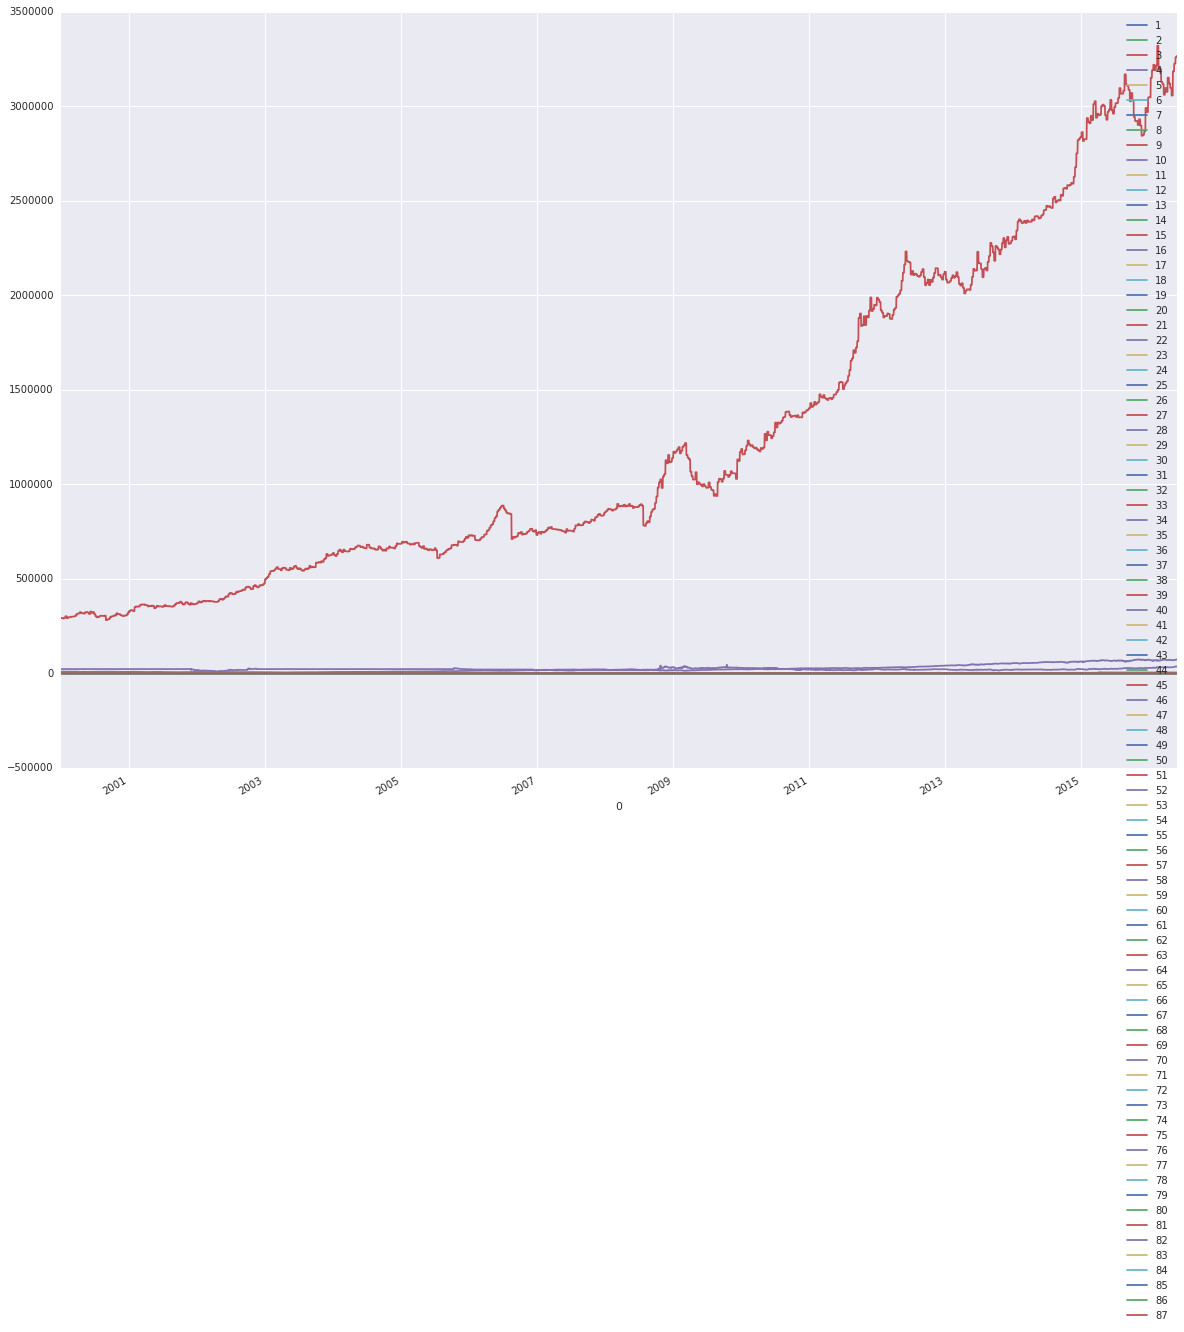

In [28]:
# N.B. A super-useful trick-ette is to assign the return value of plot to _ 
# so that you don't get text printed before the plot itself.

# _ = pd.concat([data_values_indexed[1],
#   data_values_indexed[1070],
#   data_values_indexed[788],
#   data_values_indexed[926]], axis=1).plot(figsize=(20, 15))

_ = df_values_indexed.plot(figsize=(20, 15))

As expected, the structure isn't uniformly visible for the indices. Divide each value in an individual index by the maximum value for that index., and then replot. The maximum value of all indices will be 1.

## 12) Calculate the max value for each column, prepare to scale data for each column

In [29]:
df_values_indexed_max = df_values_indexed.max(axis=0) # max across axis 0 = rows
df_values_indexed_max.head()

1     19.1476
2     19.1476
3    290.2600
4     57.0200
5    146.1300
dtype: float64

## 13) Scale the data

In [30]:
df_values_indexed_scaled = df_values_indexed / df_values_indexed_max
df_values_indexed_scaled.head()

,1,2,3,4,5,6,7,8,9,10,...,78,79,80,81,82,83,84,85,86,87
0,,,,,,,,,,,,,,,,,,,,,
2016-05-27,0.965421,0.964878,0.998932,0.971589,0.966810,0.061136,0.999107,0.776084,0.778191,0.789677,...,0.266921,0.272183,-0.072803,-0.118812,-0.291521,0.246386,0.263767,0.321429,0.278692,0.913796
2016-05-26,0.964878,0.963797,0.980776,0.969660,0.970574,0.061692,0.999062,0.775672,0.769327,0.782403,...,0.267175,0.272311,-0.071639,-0.116502,-0.289677,0.244484,0.261669,0.320223,0.276897,0.915047
2016-05-25,0.963797,0.965406,0.969476,0.987899,0.964757,0.777330,0.998883,0.773634,0.776895,0.790452,...,0.267556,0.272438,-0.076091,-0.121452,-0.295207,0.247908,0.264848,0.323282,0.279295,0.913648
2016-05-24,0.965406,0.965500,0.974333,0.983164,0.965989,0.777330,0.998794,0.774039,0.787991,0.800951,...,0.269968,0.274729,-0.076570,-0.121650,-0.294378,0.246881,0.263296,0.321052,0.277115,0.914605
2016-05-23,0.965500,0.967019,0.971612,0.969309,0.967016,0.777330,0.998794,0.785065,0.789695,0.812696,...,0.265651,0.270528,-0.074036,-0.119736,-0.290783,0.244040,0.260753,0.318264,0.274808,0.914826


## 14) Plot the scaled data

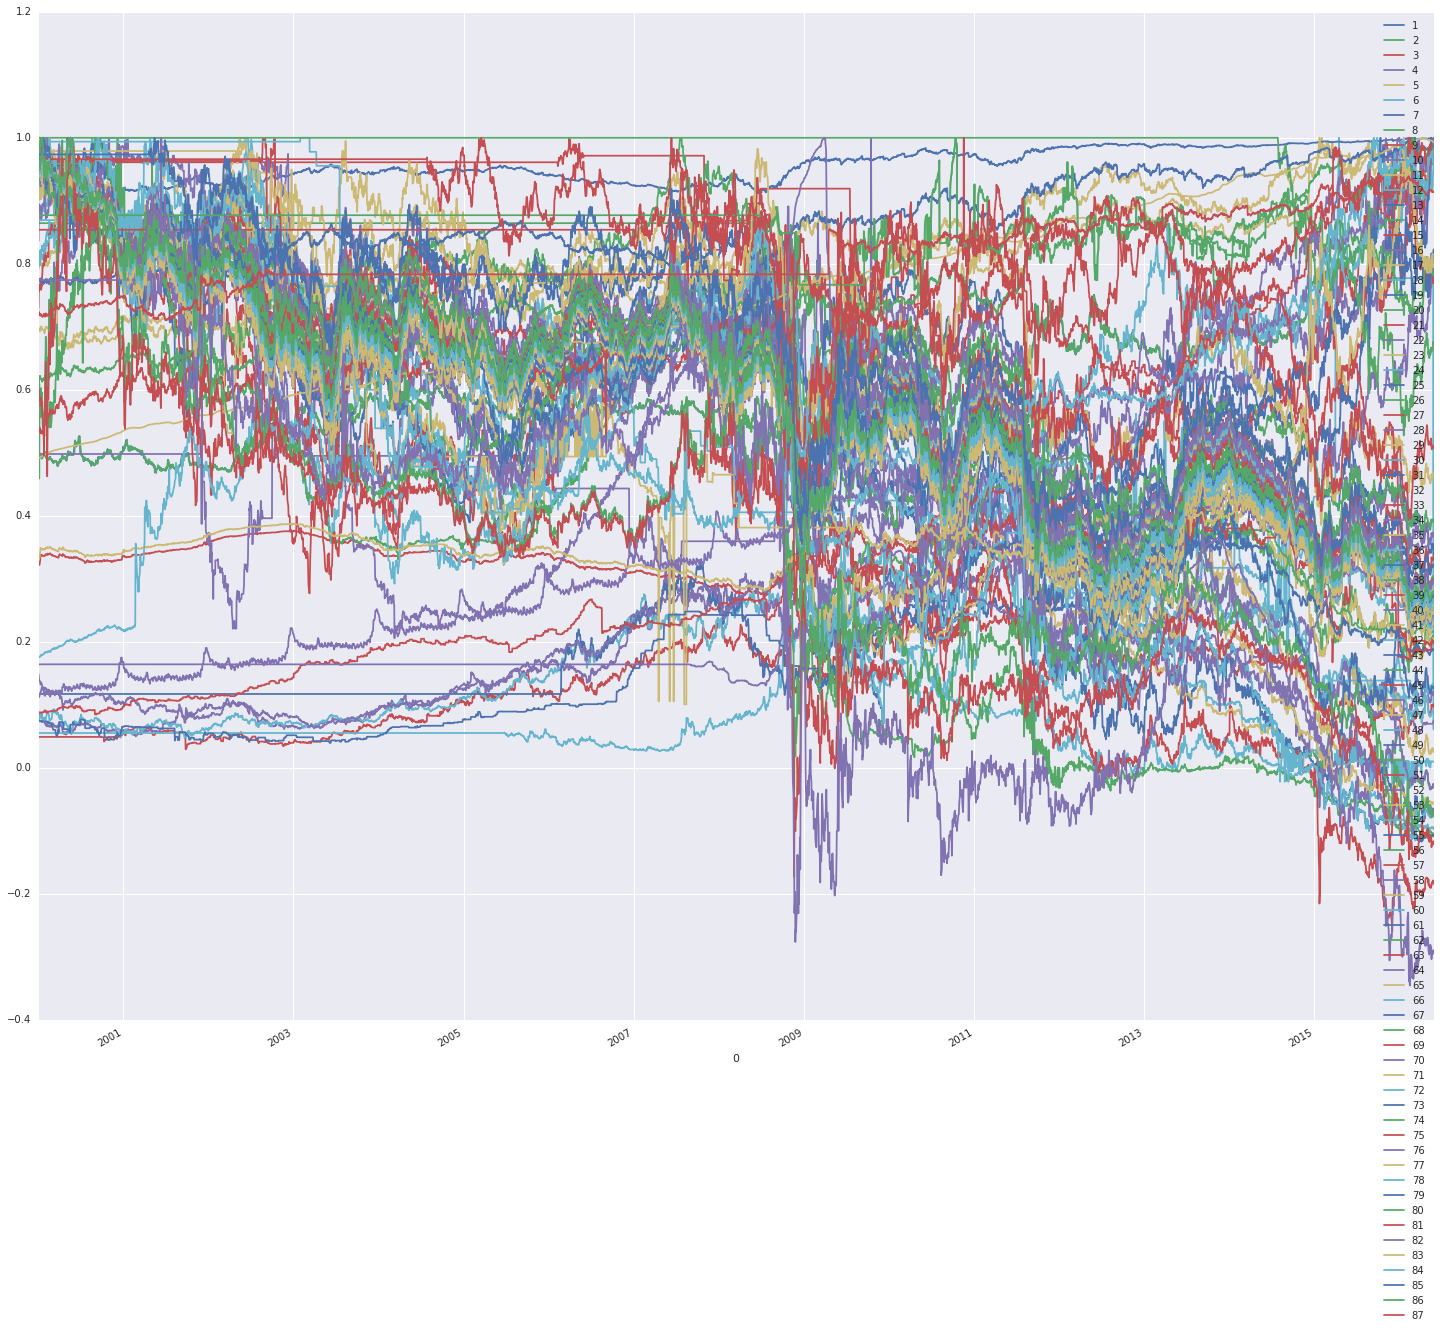

In [32]:
_ = df_values_indexed_scaled.plot(figsize=(25, 20))

## Shortform

In [33]:
dvis = df_values_indexed_scaled

## 15) Auto-correlations

Next, plot autocorrelations for each of the indices. The autocorrelations determine correlations between current values of the index and lagged values of the same index. The goal is to determine whether the lagged values are reliable indicators of the current values. If they are, then we've identified a correlation.

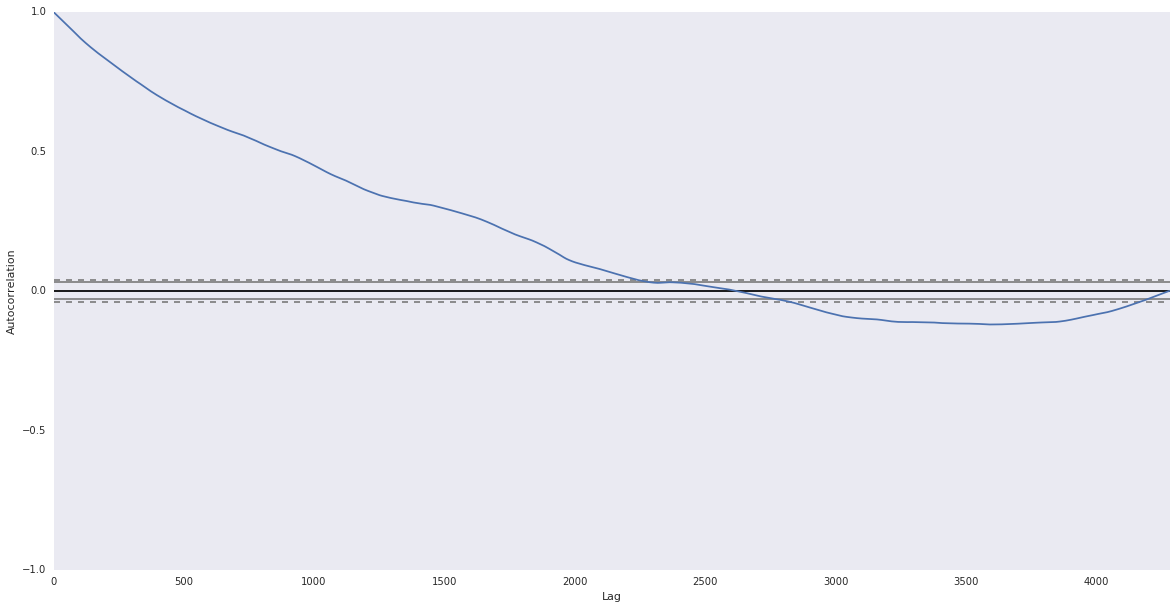

In [34]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(10)

_ = autocorrelation_plot(dvis)

For 2300 lagged days, we observe positive auto-correlations.
This suggests that as the variables increase, they tend to keep on increasing. Momentum.

After 2300 lagged days, we observe negative auto-correlations.

## 16) Skip: Just a reminder of the PCA columns we selected earlier

In [35]:
# list_cols_pca = [ 0,1,
#                   1070,788,926,112,69,574,654,1160,527,323,
#                   397,118,774,1028,1034,655,907,736,251,388,
#                   327,243,705,303,1146,467,136,1006,600,15,
#                   231,290,131,782,20,1048,630,1173,431,856,
#                   67,299,838,639,53,932,870,938,1061
#                 ]

## 17) Scatter plots of the first 20 of our 86 variables vs USDMXN(varid=1)

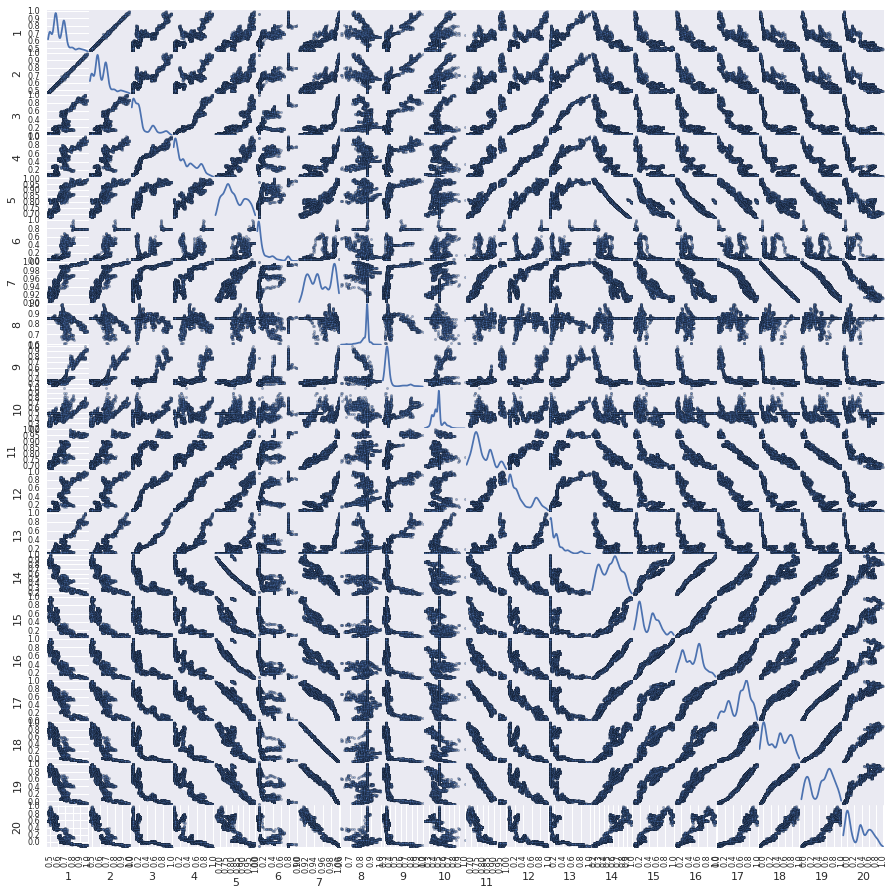

In [36]:
# _ = scatter_matrix(data_values_indexed_scaled)
# dvis = df_values_indexed_scaled

_ = scatter_matrix(
      pd.concat(
      [ 
        dvis[ 1],dvis[ 2],dvis[ 3],dvis[ 4],dvis[ 5],dvis[ 6],dvis[ 7],dvis[ 8],dvis[ 9],dvis[10],
        dvis[11],dvis[12],dvis[13],dvis[14],dvis[15],dvis[16],dvis[17],dvis[18],dvis[19],dvis[20],
      ], axis=1), figsize=(15, 15), diagonal='kde')

## 18) Remind ourselves what our scaled data (of price or index LEVELS) looks like

In [33]:
dvis.head()

,1,2,3,4,5,6,7,8,9,10,...,78,79,80,81,82,83,84,85,86,87
0,,,,,,,,,,,,,,,,,,,,,
2016-05-27,0.965421,0.964878,0.998932,0.971589,0.966810,0.061136,0.999107,0.776084,0.778191,0.789677,...,0.266921,0.272183,-0.072803,-0.118812,-0.291521,0.246386,0.263767,0.321429,0.278692,0.913796
2016-05-26,0.964878,0.963797,0.980776,0.969660,0.970574,0.061692,0.999062,0.775672,0.769327,0.782403,...,0.267175,0.272311,-0.071639,-0.116502,-0.289677,0.244484,0.261669,0.320223,0.276897,0.915047
2016-05-25,0.963797,0.965406,0.969476,0.987899,0.964757,0.777330,0.998883,0.773634,0.776895,0.790452,...,0.267556,0.272438,-0.076091,-0.121452,-0.295207,0.247908,0.264848,0.323282,0.279295,0.913648
2016-05-24,0.965406,0.965500,0.974333,0.983164,0.965989,0.777330,0.998794,0.774039,0.787991,0.800951,...,0.269968,0.274729,-0.076570,-0.121650,-0.294378,0.246881,0.263296,0.321052,0.277115,0.914605
2016-05-23,0.965500,0.967019,0.971612,0.969309,0.967016,0.777330,0.998794,0.785065,0.789695,0.812696,...,0.265651,0.270528,-0.074036,-0.119736,-0.290783,0.244040,0.260753,0.318264,0.274808,0.914826


## 19) Calculate Log Returns on our scaled data

In [34]:
df_values_indexed_scaled_logret = pd.DataFrame()
df_values_indexed_scaled_logret = np.log(dvis/dvis.shift(-1)) # note dates are reverse-chrono


## Shortform

In [35]:
dvislr = df_values_indexed_scaled_logret

In [36]:
dvislr.head()

,1,2,3,4,5,6,7,8,9,10,...,78,79,80,81,82,83,84,85,86,87
0,,,,,,,,,,,,,,,,,,,,,
2016-05-27,0.000563,0.001121,0.018343,0.001988,-0.003885,-0.009057,0.000045,0.000530,0.011456,0.009254,...,-0.000951,-0.000468,0.016122,0.019636,0.006343,0.007750,0.007987,0.003758,0.006461,-0.001369
2016-05-26,0.001121,-0.001668,0.011589,-0.018635,0.006011,-2.533711,0.000179,0.002631,-0.009789,-0.010235,...,-0.001425,-0.000467,-0.060287,-0.041615,-0.018910,-0.013907,-0.012077,-0.009508,-0.008621,0.001530
2016-05-25,-0.001668,-0.000097,-0.004998,0.004805,-0.001276,0.000000,0.000089,-0.000523,-0.014182,-0.013194,...,-0.008977,-0.008376,-0.006281,-0.001629,0.002814,0.004152,0.005876,0.006923,0.007834,-0.001047
2016-05-24,-0.000097,-0.001573,0.002797,0.014192,-0.001062,0.000000,0.000000,-0.014144,-0.002160,-0.014558,...,0.016122,0.015410,0.033655,0.015860,0.012286,0.011572,0.009707,0.008721,0.008362,-0.000241
2016-05-23,-0.001573,0.009202,-0.010371,0.001630,0.000000,0.000000,0.000000,0.008355,0.008190,0.027879,...,-0.000478,0.000942,-0.011954,-0.010965,-0.019772,-0.001039,-0.000098,0.000474,0.000373,0.000000


In [37]:
dvislr.tail()

,1,2,3,4,5,6,7,8,9,10,...,78,79,80,81,82,83,84,85,86,87
0,,,,,,,,,,,,,,,,,,,,,
2000-01-07,-0.009982,-0.001567,0.0,0.031548,0.003070,0.0,0.002047,0.0,0.000000,0.0,...,-0.004005,-0.002007,-0.022728,-0.011173,0.0,-0.005398,-0.004040,0.0,-0.004046,0.003066
2000-01-06,-0.001567,0.000940,0.0,-0.031548,0.004451,0.0,0.000098,0.0,0.000000,0.0,...,0.004005,0.003348,0.011300,0.011173,0.0,-0.005369,-0.005362,0.0,-0.004030,0.001536
2000-01-05,0.000940,-0.000031,0.0,0.000000,-0.007946,0.0,0.000000,0.0,-0.007984,0.0,...,0.006711,0.004032,-0.022473,-0.022223,0.0,0.009415,0.009402,0.0,0.008075,-0.004602
2000-01-04,-0.000031,0.006951,0.0,-0.040574,-0.008475,0.0,0.000195,0.0,0.000000,0.0,...,-0.004032,0.000000,0.045462,0.044951,0.0,-0.008075,-0.008065,0.0,-0.005391,-0.005698
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
dvislr.describe()

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,1,2,3,4,5,6,7,8,9,10,...,78,79,80,81,82,83,84,85,86,87
count,4279.000000,4279.000000,4279.000000,4279.000000,4279.000000,4279.000000,4279.000000,4279.000000,4279.000000,4279.000000,...,4279.000000,4279.000000,4272.000000,4268.000000,4188.000000,4279.000000,4279.000000,4279.000000,4279.000000,4279.000000
mean,0.000154,0.000155,0.000704,0.000561,0.000041,0.000024,0.000020,-0.000025,0.000204,0.000108,...,-0.000296,-0.000291,-0.001033,-0.000457,0.003916,-0.000314,-0.000299,-0.000259,-0.000288,0.000054
std,0.006766,0.006767,0.020758,0.018348,0.004671,0.056952,0.000857,0.010165,0.007858,0.026633,...,0.014873,0.014742,0.099875,0.149852,0.309003,0.016310,0.015431,0.015251,0.015189,0.004516
min,-0.066527,-0.066527,-0.614143,-0.101624,-0.190591,-2.533711,-0.007372,-0.166175,-0.123921,-0.385704,...,-0.136928,-0.131822,-3.135494,-3.277145,-3.624341,-0.112705,-0.105936,-0.114583,-0.109933,-0.178882
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,0.070259,0.070259,0.137621,0.133531,0.020071,0.700986,0.005774,0.229973,0.108471,0.697777,...,0.072736,0.082584,1.823012,4.235250,4.605170,0.081709,0.082212,0.079560,0.085061,0.176596


In [39]:
# 2000/01/07 to 2016/05/27 = 1 header row + 4279 data rows
# print dvislr.head()
# print dvislr.tail()
print 'NumRowsIncludeHeader = len(dvislr) = ' + str(len(dvislr))

NumRowsIncludeHeader = len(dvislr) = 4280


## 20) Replace inf, NaN in data with Zero

In [40]:
dvislr = dvislr.replace([np.inf, -np.inf, np.nan], 0)
dvislr.describe()

,1,2,3,4,5,6,7,8,9,10,...,78,79,80,81,82,83,84,85,86,87
count,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,...,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000
mean,0.000154,0.000155,0.000704,0.000561,0.000041,0.000024,0.000020,-0.000025,0.000204,0.000108,...,-0.000296,-0.000291,-0.001031,-0.000455,0.003832,-0.000314,-0.000299,-0.000259,-0.000287,0.000054
std,0.006765,0.006766,0.020756,0.018346,0.004670,0.056946,0.000857,0.010163,0.007857,0.026630,...,0.014871,0.014741,0.099782,0.149642,0.305663,0.016308,0.015429,0.015249,0.015187,0.004515
min,-0.066527,-0.066527,-0.614143,-0.101624,-0.190591,-2.533711,-0.007372,-0.166175,-0.123921,-0.385704,...,-0.136928,-0.131822,-3.135494,-3.277145,-3.624341,-0.112705,-0.105936,-0.114583,-0.109933,-0.178882
25%,-0.003348,-0.003348,-0.005990,-0.008798,-0.001978,-0.003060,-0.000318,0.000000,-0.001618,-0.002285,...,-0.007909,-0.007626,-0.014193,-0.015385,-0.017404,-0.009126,-0.008614,-0.007847,-0.008084,-0.000083
50%,-0.000076,-0.000076,0.000000,0.000000,0.000085,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000506,-0.000525,0.000000,-0.000524,0.000000
75%,0.003310,0.003311,0.008082,0.009255,0.002250,0.002376,0.000407,0.000000,0.001508,0.002399,...,0.007045,0.006817,0.013674,0.015038,0.017994,0.008153,0.007748,0.007054,0.007396,0.000350
max,0.070259,0.070259,0.137621,0.133531,0.020071,0.700986,0.005774,0.229973,0.108471,0.697777,...,0.072736,0.082584,1.823012,4.235250,4.605170,0.081709,0.082212,0.079560,0.085061,0.176596


In [41]:
dvislr.head()

,1,2,3,4,5,6,7,8,9,10,...,78,79,80,81,82,83,84,85,86,87
0,,,,,,,,,,,,,,,,,,,,,
2016-05-27,0.000563,0.001121,0.018343,0.001988,-0.003885,-0.009057,0.000045,0.000530,0.011456,0.009254,...,-0.000951,-0.000468,0.016122,0.019636,0.006343,0.007750,0.007987,0.003758,0.006461,-0.001369
2016-05-26,0.001121,-0.001668,0.011589,-0.018635,0.006011,-2.533711,0.000179,0.002631,-0.009789,-0.010235,...,-0.001425,-0.000467,-0.060287,-0.041615,-0.018910,-0.013907,-0.012077,-0.009508,-0.008621,0.001530
2016-05-25,-0.001668,-0.000097,-0.004998,0.004805,-0.001276,0.000000,0.000089,-0.000523,-0.014182,-0.013194,...,-0.008977,-0.008376,-0.006281,-0.001629,0.002814,0.004152,0.005876,0.006923,0.007834,-0.001047
2016-05-24,-0.000097,-0.001573,0.002797,0.014192,-0.001062,0.000000,0.000000,-0.014144,-0.002160,-0.014558,...,0.016122,0.015410,0.033655,0.015860,0.012286,0.011572,0.009707,0.008721,0.008362,-0.000241
2016-05-23,-0.001573,0.009202,-0.010371,0.001630,0.000000,0.000000,0.000000,0.008355,0.008190,0.027879,...,-0.000478,0.000942,-0.011954,-0.010965,-0.019772,-0.001039,-0.000098,0.000474,0.000373,0.000000


In [42]:
dvislr.tail()

,1,2,3,4,5,6,7,8,9,10,...,78,79,80,81,82,83,84,85,86,87
0,,,,,,,,,,,,,,,,,,,,,
2000-01-07,-0.009982,-0.001567,0.0,0.031548,0.003070,0.0,0.002047,0.0,0.000000,0.0,...,-0.004005,-0.002007,-0.022728,-0.011173,0.0,-0.005398,-0.004040,0.0,-0.004046,0.003066
2000-01-06,-0.001567,0.000940,0.0,-0.031548,0.004451,0.0,0.000098,0.0,0.000000,0.0,...,0.004005,0.003348,0.011300,0.011173,0.0,-0.005369,-0.005362,0.0,-0.004030,0.001536
2000-01-05,0.000940,-0.000031,0.0,0.000000,-0.007946,0.0,0.000000,0.0,-0.007984,0.0,...,0.006711,0.004032,-0.022473,-0.022223,0.0,0.009415,0.009402,0.0,0.008075,-0.004602
2000-01-04,-0.000031,0.006951,0.0,-0.040574,-0.008475,0.0,0.000195,0.0,0.000000,0.0,...,-0.004032,0.000000,0.045462,0.044951,0.0,-0.008075,-0.008065,0.0,-0.005391,-0.005698
2000-01-03,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000


## 21) Skip: Fill the Gaps

In [43]:
# Pandas includes a very convenient function for filling gaps in the data.
# dvislr = dvislr.fillna(method='ffill')
# dvislr.head()

## 22) Plot log returns of scaled data

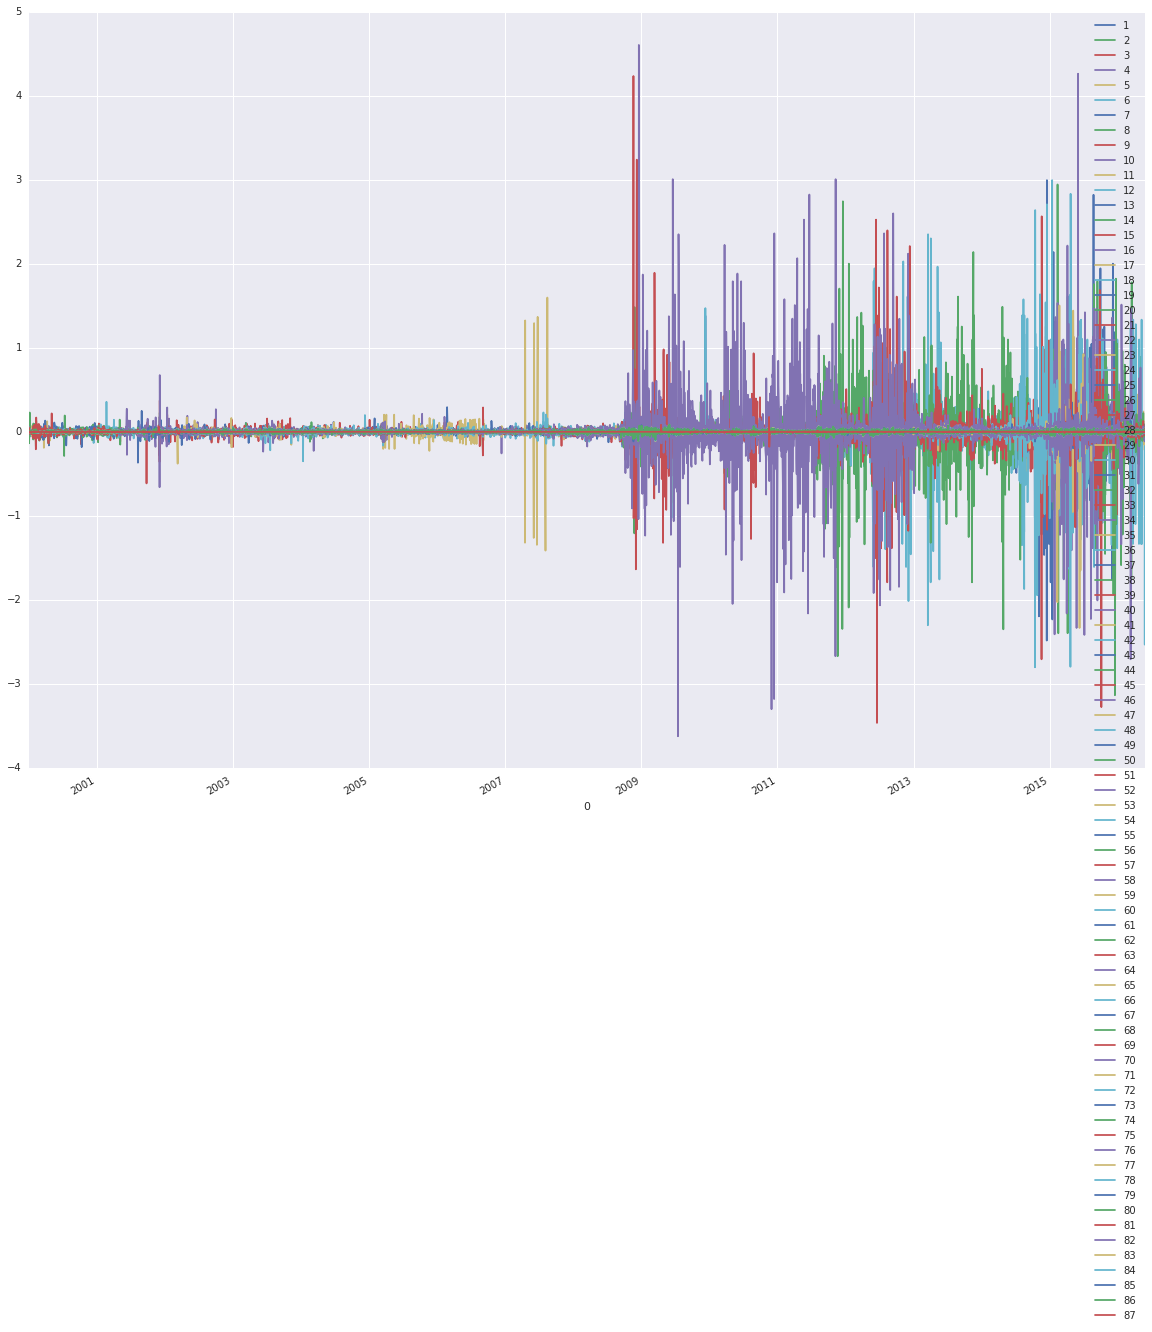

In [44]:
_ = dvislr.plot(figsize=(20, 15))

## 23) Auto-Correlations of log returns of scaled data

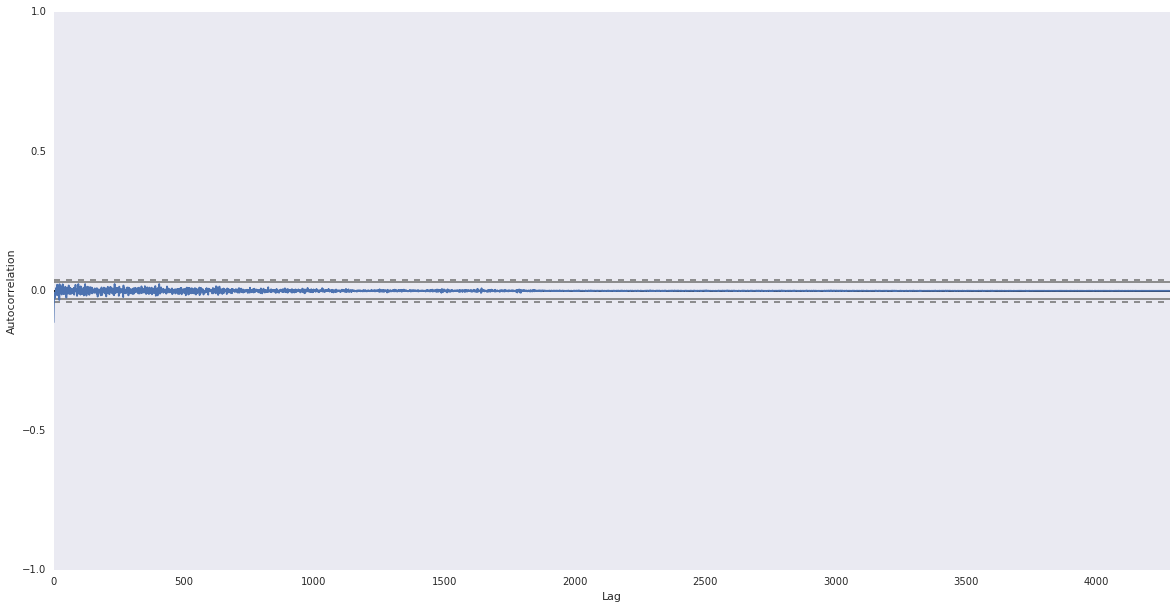

In [45]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(10)

_ = autocorrelation_plot(dvislr)

There are no auto-correlations, so we are good.

## 24) Skip: Just a reminder of the PCA50 Columns we selected earlier

In [46]:
# list_cols_pca = [ 0,1,
#                   1070,788,926,112,69,574,654,1160,527,323,
#                   397,118,774,1028,1034,655,907,736,251,388,
#                   327,243,705,303,1146,467,136,1006,600,15,
#                   231,290,131,782,20,1048,630,1173,431,856,
#                   67,299,838,639,53,932,870,938,1061
#                 ]

## 25) Scatter plots of log returns of first 20 of the 86 variables where log-returns of USDMXN(varid=1)

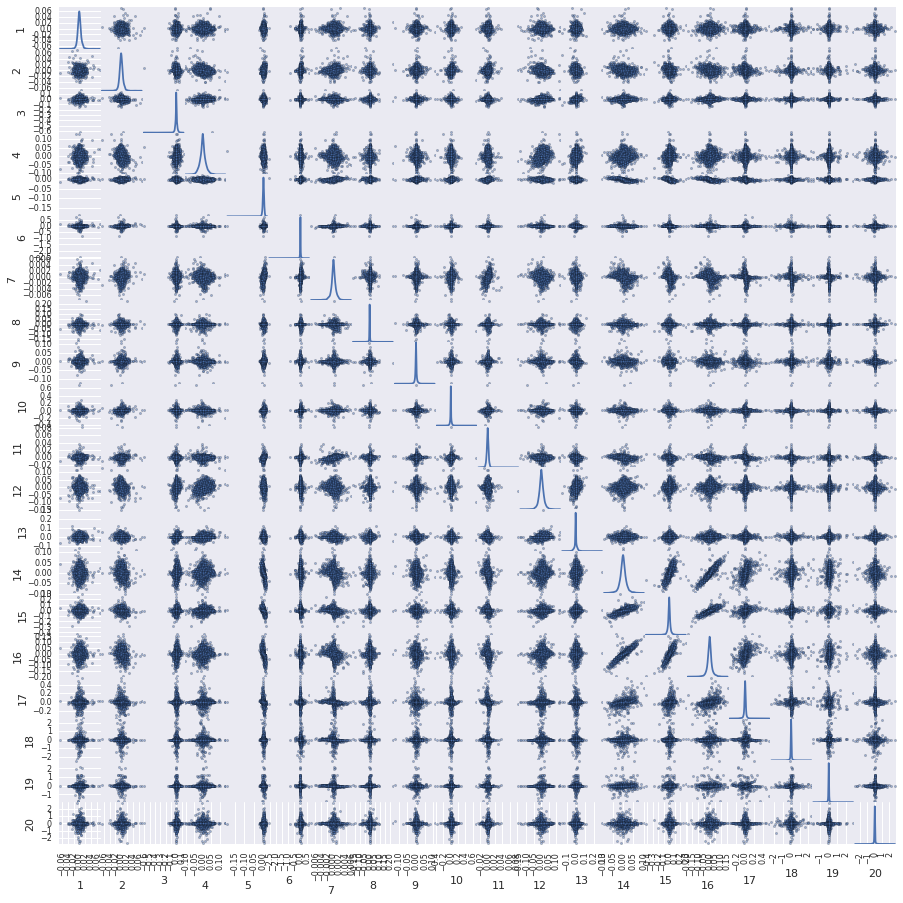

In [47]:
# _ = scatter_matrix(data_values_indexed_scaled_logret)   # takes long time, becareful, save work first
# dvislr = df_values_indexed_scaled_logret

_ = scatter_matrix(
      pd.concat(
      [ 
        dvislr[ 1],dvislr[ 2],dvislr[ 3],dvislr[ 4],dvislr[ 5],dvislr[ 6],dvislr[ 7],dvislr[ 8],dvislr[ 9],dvislr[10],
        dvislr[11],dvislr[12],dvislr[13],dvislr[14],dvislr[15],dvislr[16],dvislr[17],dvislr[18],dvislr[19],dvislr[20],
      ], axis=1), figsize=(15, 15), diagonal='kde')


## Summing up the EDA

At this point, you've done a good enough job of exploratory data analysis. You've visualized our data and come to know it better. 
You've transformed it into a form that is useful for modelling, log returns, and looked at how indices relate to each other. 

What should we think so far?

Cloud Datalab is working great. With just a few lines of code, you were able to munge the data, visualize the changes, and make decisions. You could easily analyze and iterate. This is a common feature of iPython, but the advantage here is that Cloud Datalab is a managed service that you can simply click and use, so you can focus on your analysis.

## Feature selection

At this point, we can see a model:

* We'll predict whether the USDMXN close today will be higher or lower than yesterday.

Predicting whether the log return of the USDMXN is positive or negative is a classification problem. 
That is, we want to choose one option from a finite set of options, in this case positive or negative. 
This is the base case of classification where we have only two values to choose from, known as binary classification, or logistic regression.

Machine learning models are very good at finding weak signals from data.
In machine learning, as in most things, there are subtle tradeoffs happening, but in general good data is better than good algorithms, which are better than good frameworks. 
You need all three pillars but in that order of importance: data, algorithms, frameworks.

## TensorFlow

[TensorFlow](https://tensorflow.org) is an open source software library, initiated by Google, for numerical computation using data flow graphs. TensorFlow is based on Google's machine learning expertise and is the next generation framework used internally at Google for tasks such as translation and image recognition. It's a wonderful framework for machine learning because it's expressive, efficient, and easy to use.

### Feature engineering for TensorFlow

From a training and testing perspective, time series data is easy. Training data should come from events that happened before test data events, and be contiguous in time.  Otherwise,  your model would be trained on events from "the future", at least as compared to the test data. It would then likely perform badly in practice, because you can’t really have access to data from the future. That means random sampling or cross validation don't apply to time series data. Decide on a training-versus-testing split, and divide your data into training and test datasets.

In this case, you'll create the features together with two additional columns:

* usdmxn_logret_positive, which is 1 if the log return of the USDMXN close is positive, and 0 otherwise. 
* usdmxn_logret_negative, which is 1 if the log return of the USDMXN close is negative, and 1 otherwise. 

We'll use 80% of our data for training and 20% for testing.

# Model 1: Binary Classification (BC) = Logistic Regression (LR)

## Model 1: Step 01: Indicator Columns

In [48]:
# 00: Original: Initialize indicator columns to 0
#    0,   1,   2,  3, ..,  87
# date, Tp1, Tp0, v1, .., v85

#    0,   1,   2,  3, ..,  82
# date, Tp1, Tp0, v1, .., v80

dvislr['usdmxn_Tp1_logret_positive'] = 0 # col 88  ---> col (82+1)
dvislr['usdmxn_Tp1_logret_negative'] = 0 # col 89

dvislr['usdmxn_Tp0_logret_positive'] = 0 # col 90
dvislr['usdmxn_Tp0_logret_negative'] = 0 # col 91


In [49]:
dvislr.head()

,1,2,3,4,5,6,7,8,9,10,...,82,83,84,85,86,87,usdmxn_Tp1_logret_positive,usdmxn_Tp1_logret_negative,usdmxn_Tp0_logret_positive,usdmxn_Tp0_logret_negative
0,,,,,,,,,,,,,,,,,,,,,
2016-05-27,0.000563,0.001121,0.018343,0.001988,-0.003885,-0.009057,0.000045,0.000530,0.011456,0.009254,...,0.006343,0.007750,0.007987,0.003758,0.006461,-0.001369,0,0,0,0
2016-05-26,0.001121,-0.001668,0.011589,-0.018635,0.006011,-2.533711,0.000179,0.002631,-0.009789,-0.010235,...,-0.018910,-0.013907,-0.012077,-0.009508,-0.008621,0.001530,0,0,0,0
2016-05-25,-0.001668,-0.000097,-0.004998,0.004805,-0.001276,0.000000,0.000089,-0.000523,-0.014182,-0.013194,...,0.002814,0.004152,0.005876,0.006923,0.007834,-0.001047,0,0,0,0
2016-05-24,-0.000097,-0.001573,0.002797,0.014192,-0.001062,0.000000,0.000000,-0.014144,-0.002160,-0.014558,...,0.012286,0.011572,0.009707,0.008721,0.008362,-0.000241,0,0,0,0
2016-05-23,-0.001573,0.009202,-0.010371,0.001630,0.000000,0.000000,0.000000,0.008355,0.008190,0.027879,...,-0.019772,-0.001039,-0.000098,0.000474,0.000373,0.000000,0,0,0,0


In [50]:
# 00: Populate results columns according to actual usdmxn returns (positive or negative)

# Predicting T+1: use col 1
dvislr.ix[dvislr[1] >= 0, 'usdmxn_Tp1_logret_positive'] = 1
dvislr.ix[dvislr[1] <  0, 'usdmxn_Tp1_logret_negative'] = 1

# Predicting T+0: use col 2
dvislr.ix[dvislr[2] >= 0, 'usdmxn_Tp0_logret_positive'] = 1
dvislr.ix[dvislr[2] <  0, 'usdmxn_Tp0_logret_negative'] = 1

In [51]:
# 01: Noise Cancellation
# dvislr['usdmxn_Tp0_logret_positive_0050bp'] = 0
# dvislr['usdmxn_Tp0_logret_negative_0050bp'] = 0

In [52]:
# 01: Populate results columns according to actual usdmxn returns (outside noise zone above or below)
# dvislr.ix[dvislr[2] >= 0.0050, 'usdmxn_Tp0_logret_positive_0050bp'] = 1
# dvislr.ix[dvislr[2] <  -0.0050, 'usdmxn_Tp0_logret_negative_0050bp'] = 1

In [53]:
# # 02: Stratification
# dvislr['usdmxn_Tp0_logret_+0150bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_+0150bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_+0140bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_+0140bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_+0130bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_+0130bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_+0120bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_+0120bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_+0110bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_+0110bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_+0100bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_+0100bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_+0090bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_+0090bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_+0080bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_+0080bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_+0070bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_+0070bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_+0060bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_+0060bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_+0050bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_+0050bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_+0040bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_+0040bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_+0030bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_+0030bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_+0020bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_+0020bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_+0010bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_+0010bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_+0000bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_+0000bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_-0010bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_-0010bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_-0020bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_-0020bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_-0030bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_-0030bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_-0040bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_-0040bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_-0050bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_-0050bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_-0060bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_-0060bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_-0070bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_-0070bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_-0080bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_-0080bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_-0090bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_-0090bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_-0100bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_-0100bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_-0110bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_-0110bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_-0120bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_-0120bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_-0130bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_-0130bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_-0140bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_-0140bp_and_below'] = 0;
# dvislr['usdmxn_Tp0_logret_-0150bp_and_above'] = 0; dvislr['usdmxn_Tp0_logret_-0150bp_and_below'] = 0;

In [54]:
# 02: Tp1 Stratification Initialize
# WIP

In [55]:
# 02: Tp0 Stratification: Populate 
# WIP

In [56]:
# 02: Tp0 Stratification: Initialize
for d_bp in xrange(-150,160,10): # -150:10:+150
  d = d_bp / 10000.00
  s_Tp0_above = 'usdmxn_Tp0_logret_' + '{0:+05d}'.format(d_bp) + 'bp_and_above'
  s_Tp0_below = 'usdmxn_Tp0_logret_' + '{0:+05d}'.format(d_bp) + 'bp_and_below'
  # print d
  # print s_above
  # print s_below
  dvislr[s_Tp0_above] = 0;
  dvislr[s_Tp0_below] = 0;

In [57]:
# 02: Tp0 Stratification: Populate results columns according to actual usdmxn returns (above or below each level)
for d_bp in xrange(-150,160,10): # -150:10:+150
  d = d_bp / 10000.00
  s_Tp0_above = 'usdmxn_Tp0_logret_' + '{0:+05d}'.format(d_bp) + 'bp_and_above'
  s_Tp0_below = 'usdmxn_Tp0_logret_' + '{0:+05d}'.format(d_bp) + 'bp_and_below'
  # print d
  # print s_above
  # print s_below
  dvislr.ix[dvislr[1] >= d, s_Tp0_above] = 1
  dvislr.ix[dvislr[1] <  d, s_Tp0_below] = 1


In [58]:
dvislr.head()
# 87 inputs + 4 user cols + (15+1+15)*2=62   = 155 cols

,1,2,3,4,5,6,7,8,9,10,...,usdmxn_Tp0_logret_+0110bp_and_above,usdmxn_Tp0_logret_+0110bp_and_below,usdmxn_Tp0_logret_+0120bp_and_above,usdmxn_Tp0_logret_+0120bp_and_below,usdmxn_Tp0_logret_+0130bp_and_above,usdmxn_Tp0_logret_+0130bp_and_below,usdmxn_Tp0_logret_+0140bp_and_above,usdmxn_Tp0_logret_+0140bp_and_below,usdmxn_Tp0_logret_+0150bp_and_above,usdmxn_Tp0_logret_+0150bp_and_below
0,,,,,,,,,,,,,,,,,,,,,
2016-05-27,0.000563,0.001121,0.018343,0.001988,-0.003885,-0.009057,0.000045,0.000530,0.011456,0.009254,...,0,1,0,1,0,1,0,1,0,1
2016-05-26,0.001121,-0.001668,0.011589,-0.018635,0.006011,-2.533711,0.000179,0.002631,-0.009789,-0.010235,...,0,1,0,1,0,1,0,1,0,1
2016-05-25,-0.001668,-0.000097,-0.004998,0.004805,-0.001276,0.000000,0.000089,-0.000523,-0.014182,-0.013194,...,0,1,0,1,0,1,0,1,0,1
2016-05-24,-0.000097,-0.001573,0.002797,0.014192,-0.001062,0.000000,0.000000,-0.014144,-0.002160,-0.014558,...,0,1,0,1,0,1,0,1,0,1
2016-05-23,-0.001573,0.009202,-0.010371,0.001630,0.000000,0.000000,0.000000,0.008355,0.008190,0.027879,...,0,1,0,1,0,1,0,1,0,1


In [59]:
dvislr.describe()

,1,2,3,4,5,6,7,8,9,10,...,usdmxn_Tp0_logret_+0110bp_and_above,usdmxn_Tp0_logret_+0110bp_and_below,usdmxn_Tp0_logret_+0120bp_and_above,usdmxn_Tp0_logret_+0120bp_and_below,usdmxn_Tp0_logret_+0130bp_and_above,usdmxn_Tp0_logret_+0130bp_and_below,usdmxn_Tp0_logret_+0140bp_and_above,usdmxn_Tp0_logret_+0140bp_and_below,usdmxn_Tp0_logret_+0150bp_and_above,usdmxn_Tp0_logret_+0150bp_and_below
count,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,...,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000
mean,0.000154,0.000155,0.000704,0.000561,0.000041,0.000024,0.000020,-0.000025,0.000204,0.000108,...,0.048364,0.951636,0.037850,0.962150,0.027336,0.972664,0.021729,0.978271,0.017991,0.982009
std,0.006765,0.006766,0.020756,0.018346,0.004670,0.056946,0.000857,0.010163,0.007857,0.026630,...,0.214560,0.214560,0.190857,0.190857,0.163081,0.163081,0.145814,0.145814,0.132933,0.132933
min,-0.066527,-0.066527,-0.614143,-0.101624,-0.190591,-2.533711,-0.007372,-0.166175,-0.123921,-0.385704,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.003348,-0.003348,-0.005990,-0.008798,-0.001978,-0.003060,-0.000318,0.000000,-0.001618,-0.002285,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,-0.000076,-0.000076,0.000000,0.000000,0.000085,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,0.003310,0.003311,0.008082,0.009255,0.002250,0.002376,0.000407,0.000000,0.001508,0.002399,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,0.070259,0.070259,0.137621,0.133531,0.020071,0.700986,0.005774,0.229973,0.108471,0.697777,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Model 1: Step 01.01: Remove data noise in a stratified way

In [60]:
# dvislr = data_values_indexed_scaled_logret
# dvislrnr = data_values_indexed_scaled_logret (noise removed)

# Example Filter: df[(df.A == 1) & (df.D == 6)]
dvislr_nr_m0010_z0000_p0010 = dvislr[ (dvislr['usdmxn_Tp0_logret_-0010bp_and_below'] == 1) | (dvislr['usdmxn_Tp0_logret_+0010bp_and_above'] == 1) ] # remove data between [-0.10%, +0.10%], center at +0.00%
dvislr_nr_m0020_z0000_p0020 = dvislr[ (dvislr['usdmxn_Tp0_logret_-0020bp_and_below'] == 1) | (dvislr['usdmxn_Tp0_logret_+0020bp_and_above'] == 1) ] # remove data between [-0.10%, +0.10%], center at +0.00%
dvislr_nr_m0030_z0000_p0030 = dvislr[ (dvislr['usdmxn_Tp0_logret_-0030bp_and_below'] == 1) | (dvislr['usdmxn_Tp0_logret_+0030bp_and_above'] == 1) ] # remove data between [-0.10%, +0.10%], center at +0.00%
dvislr_nr_m0040_z0000_p0040 = dvislr[ (dvislr['usdmxn_Tp0_logret_-0040bp_and_below'] == 1) | (dvislr['usdmxn_Tp0_logret_+0040bp_and_above'] == 1) ] # remove data between [-0.10%, +0.10%], center at +0.00%
dvislr_nr_m0050_z0000_p0050 = dvislr[ (dvislr['usdmxn_Tp0_logret_-0050bp_and_below'] == 1) | (dvislr['usdmxn_Tp0_logret_+0050bp_and_above'] == 1) ] # remove data between [-0.50%, +0.50%], center at +0.00%
dvislr_nr_m0060_z0000_p0060 = dvislr[ (dvislr['usdmxn_Tp0_logret_-0060bp_and_below'] == 1) | (dvislr['usdmxn_Tp0_logret_+0060bp_and_above'] == 1) ] # remove data between [-0.50%, +0.50%], center at +0.00%
dvislr_nr_m0070_z0000_p0070 = dvislr[ (dvislr['usdmxn_Tp0_logret_-0070bp_and_below'] == 1) | (dvislr['usdmxn_Tp0_logret_+0070bp_and_above'] == 1) ] # remove data between [-0.50%, +0.50%], center at +0.00%
dvislr_nr_m0080_z0000_p0080 = dvislr[ (dvislr['usdmxn_Tp0_logret_-0080bp_and_below'] == 1) | (dvislr['usdmxn_Tp0_logret_+0080bp_and_above'] == 1) ] # remove data between [-0.50%, +0.50%], center at +0.00%
dvislr_nr_m0090_z0000_p0090 = dvislr[ (dvislr['usdmxn_Tp0_logret_-0090bp_and_below'] == 1) | (dvislr['usdmxn_Tp0_logret_+0090bp_and_above'] == 1) ] # remove data between [-0.50%, +0.50%], center at +0.00%
dvislr_nr_m0100_z0000_p0100 = dvislr[ (dvislr['usdmxn_Tp0_logret_-0100bp_and_below'] == 1) | (dvislr['usdmxn_Tp0_logret_+0100bp_and_above'] == 1) ] # remove data between [-0.50%, +0.50%], center at +0.00%

# check rows
print 'dvislr_nr_m0010_z0000_p0010 rows =' + str(len(dvislr_nr_m0010_z0000_p0010))
print 'dvislr_nr_m0020_z0000_p0020 rows =' + str(len(dvislr_nr_m0020_z0000_p0020))
print 'dvislr_nr_m0030_z0000_p0030 rows =' + str(len(dvislr_nr_m0030_z0000_p0030))
print 'dvislr_nr_m0040_z0000_p0040 rows =' + str(len(dvislr_nr_m0040_z0000_p0040))
print 'dvislr_nr_m0050_z0000_p0050 rows =' + str(len(dvislr_nr_m0050_z0000_p0050))
print 'dvislr_nr_m0060_z0000_p0060 rows =' + str(len(dvislr_nr_m0060_z0000_p0060))
print 'dvislr_nr_m0070_z0000_p0070 rows =' + str(len(dvislr_nr_m0070_z0000_p0070))
print 'dvislr_nr_m0080_z0000_p0080 rows =' + str(len(dvislr_nr_m0080_z0000_p0080))
print 'dvislr_nr_m0090_z0000_p0090 rows =' + str(len(dvislr_nr_m0090_z0000_p0090))
print 'dvislr_nr_m0100_z0000_p0100 rows =' + str(len(dvislr_nr_m0100_z0000_p0100))

# check rows results
# dvislr_nr_m0010_z0000_p0010 rows =3553
# dvislr_nr_m0020_z0000_p0020 rows =2903
# dvislr_nr_m0030_z0000_p0030 rows =2315
# dvislr_nr_m0040_z0000_p0040 rows =1836
# dvislr_nr_m0050_z0000_p0050 rows =1436
# dvislr_nr_m0060_z0000_p0060 rows =1134
# dvislr_nr_m0070_z0000_p0070 rows =893
# dvislr_nr_m0080_z0000_p0080 rows =697
# dvislr_nr_m0090_z0000_p0090 rows =559
# dvislr_nr_m0100_z0000_p0100 rows =439

dvislr_nr_m0010_z0000_p0010 rows =3553
dvislr_nr_m0020_z0000_p0020 rows =2903
dvislr_nr_m0030_z0000_p0030 rows =2315
dvislr_nr_m0040_z0000_p0040 rows =1836
dvislr_nr_m0050_z0000_p0050 rows =1436
dvislr_nr_m0060_z0000_p0060 rows =1134
dvislr_nr_m0070_z0000_p0070 rows =893
dvislr_nr_m0080_z0000_p0080 rows =697
dvislr_nr_m0090_z0000_p0090 rows =559
dvislr_nr_m0100_z0000_p0100 rows =439


## Model 1: Step 02: Split data into training, test

### training test data empty shell

In [61]:
# training_test_data
# col 001-002 = 02 cols = Tp1 up dn indicators of results
# col 003-004 = 02 cols = Tp0 up dn indicators of results
# col 005-066 = 62 cols = (15+1+15)*2
# col 067-153 = 87 cols = 87 inputs
training_test_data = pd.DataFrame(
  columns=[
    # 'usdmxn_Tp0_logret_positive',        'usdmxn_Tp0_logret_negative',
    # 'usdmxn_Tp0_logret_positive_0050bp', 'usdmxn_Tp0_logret_negative_0050bp',

    'bc_Tp1_up', 
    'bc_Tp1_dn',
    
    'bc_Tp0_up', 
    'bc_Tp0_dn',
    
    'usdmxn_Tp0_logret_-0150bp_and_above', 'usdmxn_Tp0_logret_-0150bp_and_below',
    'usdmxn_Tp0_logret_-0140bp_and_above', 'usdmxn_Tp0_logret_-0140bp_and_below',
    'usdmxn_Tp0_logret_-0130bp_and_above', 'usdmxn_Tp0_logret_-0130bp_and_below',
    'usdmxn_Tp0_logret_-0120bp_and_above', 'usdmxn_Tp0_logret_-0120bp_and_below',
    'usdmxn_Tp0_logret_-0110bp_and_above', 'usdmxn_Tp0_logret_-0110bp_and_below',
    'usdmxn_Tp0_logret_-0100bp_and_above', 'usdmxn_Tp0_logret_-0100bp_and_below',
    'usdmxn_Tp0_logret_-0090bp_and_above', 'usdmxn_Tp0_logret_-0090bp_and_below',
    'usdmxn_Tp0_logret_-0080bp_and_above', 'usdmxn_Tp0_logret_-0080bp_and_below',
    'usdmxn_Tp0_logret_-0070bp_and_above', 'usdmxn_Tp0_logret_-0070bp_and_below',
    'usdmxn_Tp0_logret_-0060bp_and_above', 'usdmxn_Tp0_logret_-0060bp_and_below',
    'usdmxn_Tp0_logret_-0050bp_and_above', 'usdmxn_Tp0_logret_-0050bp_and_below',
    'usdmxn_Tp0_logret_-0040bp_and_above', 'usdmxn_Tp0_logret_-0040bp_and_below',
    'usdmxn_Tp0_logret_-0030bp_and_above', 'usdmxn_Tp0_logret_-0030bp_and_below',
    'usdmxn_Tp0_logret_-0020bp_and_above', 'usdmxn_Tp0_logret_-0020bp_and_below',
    'usdmxn_Tp0_logret_-0010bp_and_above', 'usdmxn_Tp0_logret_-0010bp_and_below',
    'usdmxn_Tp0_logret_+0000bp_and_above', 'usdmxn_Tp0_logret_+0000bp_and_below',
    'usdmxn_Tp0_logret_+0010bp_and_above', 'usdmxn_Tp0_logret_+0010bp_and_below',
    'usdmxn_Tp0_logret_+0020bp_and_above', 'usdmxn_Tp0_logret_+0020bp_and_below',
    'usdmxn_Tp0_logret_+0030bp_and_above', 'usdmxn_Tp0_logret_+0030bp_and_below',
    'usdmxn_Tp0_logret_+0040bp_and_above', 'usdmxn_Tp0_logret_+0040bp_and_below',
    'usdmxn_Tp0_logret_+0050bp_and_above', 'usdmxn_Tp0_logret_+0050bp_and_below',
    'usdmxn_Tp0_logret_+0060bp_and_above', 'usdmxn_Tp0_logret_+0060bp_and_below',
    'usdmxn_Tp0_logret_+0070bp_and_above', 'usdmxn_Tp0_logret_+0070bp_and_below',
    'usdmxn_Tp0_logret_+0080bp_and_above', 'usdmxn_Tp0_logret_+0080bp_and_below',
    'usdmxn_Tp0_logret_+0090bp_and_above', 'usdmxn_Tp0_logret_+0090bp_and_below',
    'usdmxn_Tp0_logret_+0100bp_and_above', 'usdmxn_Tp0_logret_+0100bp_and_below',
    'usdmxn_Tp0_logret_+0110bp_and_above', 'usdmxn_Tp0_logret_+0110bp_and_below',
    'usdmxn_Tp0_logret_+0120bp_and_above', 'usdmxn_Tp0_logret_+0120bp_and_below',
    'usdmxn_Tp0_logret_+0130bp_and_above', 'usdmxn_Tp0_logret_+0130bp_and_below',
    'usdmxn_Tp0_logret_+0140bp_and_above', 'usdmxn_Tp0_logret_+0140bp_and_below',
    'usdmxn_Tp0_logret_+0150bp_and_above', 'usdmxn_Tp0_logret_+0150bp_and_below',

    # XXX 1st - change this
    '1','2','3','4','5','6','7','8','9','10',
    '11','12','13','14','15','16','17','18','19','20',
    '21','22','23','24','25','26','27','28','29','30',
    '31','32','33','34','35','36','37','38','39','40',
    '41','42','43','44','45','46','47','48','49','50',
    '51','52','53','54','55','56','57','58','59','60',
    '61','62','63','64','65','66','67','68','69','70',
    '71','72','73','74','75','76','77','78','79','80',
    '81','82','83','84','85','86','87'
  ])

training_test_data.head()

,bc_Tp1_up,bc_Tp1_dn,bc_Tp0_up,bc_Tp0_dn,usdmxn_Tp0_logret_-0150bp_and_above,usdmxn_Tp0_logret_-0150bp_and_below,usdmxn_Tp0_logret_-0140bp_and_above,usdmxn_Tp0_logret_-0140bp_and_below,usdmxn_Tp0_logret_-0130bp_and_above,usdmxn_Tp0_logret_-0130bp_and_below,...,78,79,80,81,82,83,84,85,86,87


In [62]:
len(dvislr)

4280

### Read data into variables

In [63]:
# row 0      = header
# row 1-4279 = data
# NumRowsIncludeHeader = len(data_values_indexed_scaled_logret) = 4280 = 0-4279
# Start from row 7, so we can have up to (7-1) lookback days

# check rows results
# dvislr_nr_m0010_z0000_p0010 rows =3554
# dvislr_nr_m0020_z0000_p0020 rows =2904
# dvislr_nr_m0030_z0000_p0030 rows =2316
# dvislr_nr_m0040_z0000_p0040 rows =1837
# dvislr_nr_m0050_z0000_p0050 rows =1437
# dvislr_nr_m0060_z0000_p0060 rows =1135
# dvislr_nr_m0070_z0000_p0070 rows =893
# dvislr_nr_m0080_z0000_p0080 rows =697
# dvislr_nr_m0090_z0000_p0090 rows =559
# dvislr_nr_m0100_z0000_p0100 rows =439

#==========================================================================================
# Select the data
#==========================================================================================
# dvislr =  dvislr                          # default
# dvislr =  dvislr_nr_m0010_z0000_p0010
# dvislr =  dvislr_nr_m0020_z0000_p0020
# dvislr =  dvislr_nr_m0030_z0000_p0030
# dvislr =  dvislr_nr_m0040_z0000_p0040
# dvislr =  dvislr_nr_m0050_z0000_p0050
# dvislr =  dvislr_nr_m0060_z0000_p0060
# dvislr =  dvislr_nr_m0070_z0000_p0070
# dvislr =  dvislr_nr_m0080_z0000_p0080
# dvislr =  dvislr_nr_m0090_z0000_p0090
# dvislr =  dvislr_nr_m0100_z0000_p0100

# for row i
for i in range(7, len(dvislr)): # = range(7, 4280) =  [7, 4280) = [7,4279] 

  #==========================================================================================
  usdmxn_Tp1_logret_positive = dvislr['usdmxn_Tp1_logret_positive'].ix[i] # col 1
  usdmxn_Tp1_logret_negative = dvislr['usdmxn_Tp1_logret_negative'].ix[i] # col 2
  usdmxn_Tp0_logret_positive = dvislr['usdmxn_Tp0_logret_positive'].ix[i] # col 3
  usdmxn_Tp0_logret_negative = dvislr['usdmxn_Tp0_logret_negative'].ix[i] # col 4
  #==========================================================================================
  bc_Tp1_up = usdmxn_Tp1_logret_positive; # Tp1 up # col 1
  bc_Tp1_dn = usdmxn_Tp1_logret_negative; # Tp1 dn # col 2
  bc_Tp0_up = usdmxn_Tp0_logret_positive; # Tp0 up # col 3
  bc_Tp0_dn = usdmxn_Tp0_logret_negative; # Tp0 dn # col 4
  #==========================================================================================

  # 02: stratification  
  usdmxn_Tp0_logret_p0150bp_and_below = dvislr['usdmxn_Tp0_logret_+0150bp_and_below'].ix[i]; usdmxn_Tp0_logret_p0150bp_and_above = dvislr['usdmxn_Tp0_logret_+0150bp_and_above'].ix[i];
  usdmxn_Tp0_logret_p0140bp_and_below = dvislr['usdmxn_Tp0_logret_+0140bp_and_below'].ix[i]; usdmxn_Tp0_logret_p0140bp_and_above = dvislr['usdmxn_Tp0_logret_+0140bp_and_above'].ix[i];
  usdmxn_Tp0_logret_p0130bp_and_below = dvislr['usdmxn_Tp0_logret_+0130bp_and_below'].ix[i]; usdmxn_Tp0_logret_p0130bp_and_above = dvislr['usdmxn_Tp0_logret_+0130bp_and_above'].ix[i];
  usdmxn_Tp0_logret_p0120bp_and_below = dvislr['usdmxn_Tp0_logret_+0120bp_and_below'].ix[i]; usdmxn_Tp0_logret_p0120bp_and_above = dvislr['usdmxn_Tp0_logret_+0120bp_and_above'].ix[i];
  usdmxn_Tp0_logret_p0110bp_and_below = dvislr['usdmxn_Tp0_logret_+0110bp_and_below'].ix[i]; usdmxn_Tp0_logret_p0110bp_and_above = dvislr['usdmxn_Tp0_logret_+0110bp_and_above'].ix[i];
  
  usdmxn_Tp0_logret_p0100bp_and_below = dvislr['usdmxn_Tp0_logret_+0100bp_and_below'].ix[i]; usdmxn_Tp0_logret_p0100bp_and_above = dvislr['usdmxn_Tp0_logret_+0100bp_and_above'].ix[i];
  usdmxn_Tp0_logret_p0090bp_and_below = dvislr['usdmxn_Tp0_logret_+0090bp_and_below'].ix[i]; usdmxn_Tp0_logret_p0090bp_and_above = dvislr['usdmxn_Tp0_logret_+0090bp_and_above'].ix[i];
  usdmxn_Tp0_logret_p0080bp_and_below = dvislr['usdmxn_Tp0_logret_+0080bp_and_below'].ix[i]; usdmxn_Tp0_logret_p0080bp_and_above = dvislr['usdmxn_Tp0_logret_+0080bp_and_above'].ix[i];
  usdmxn_Tp0_logret_p0070bp_and_below = dvislr['usdmxn_Tp0_logret_+0070bp_and_below'].ix[i]; usdmxn_Tp0_logret_p0070bp_and_above = dvislr['usdmxn_Tp0_logret_+0070bp_and_above'].ix[i];
  usdmxn_Tp0_logret_p0060bp_and_below = dvislr['usdmxn_Tp0_logret_+0060bp_and_below'].ix[i]; usdmxn_Tp0_logret_p0060bp_and_above = dvislr['usdmxn_Tp0_logret_+0060bp_and_above'].ix[i];

  usdmxn_Tp0_logret_p0050bp_and_below = dvislr['usdmxn_Tp0_logret_+0050bp_and_below'].ix[i]; usdmxn_Tp0_logret_p0050bp_and_above = dvislr['usdmxn_Tp0_logret_+0050bp_and_above'].ix[i];
  usdmxn_Tp0_logret_p0040bp_and_below = dvislr['usdmxn_Tp0_logret_+0040bp_and_below'].ix[i]; usdmxn_Tp0_logret_p0040bp_and_above = dvislr['usdmxn_Tp0_logret_+0040bp_and_above'].ix[i];
  usdmxn_Tp0_logret_p0030bp_and_below = dvislr['usdmxn_Tp0_logret_+0030bp_and_below'].ix[i]; usdmxn_Tp0_logret_p0030bp_and_above = dvislr['usdmxn_Tp0_logret_+0030bp_and_above'].ix[i];
  usdmxn_Tp0_logret_p0020bp_and_below = dvislr['usdmxn_Tp0_logret_+0020bp_and_below'].ix[i]; usdmxn_Tp0_logret_p0020bp_and_above = dvislr['usdmxn_Tp0_logret_+0020bp_and_above'].ix[i];
  usdmxn_Tp0_logret_p0010bp_and_below = dvislr['usdmxn_Tp0_logret_+0010bp_and_below'].ix[i]; usdmxn_Tp0_logret_p0010bp_and_above = dvislr['usdmxn_Tp0_logret_+0010bp_and_above'].ix[i];

  usdmxn_Tp0_logret_p0000bp_and_below = dvislr['usdmxn_Tp0_logret_+0000bp_and_below'].ix[i]; usdmxn_Tp0_logret_p0000bp_and_above = dvislr['usdmxn_Tp0_logret_+0000bp_and_above'].ix[i];

  usdmxn_Tp0_logret_m0010bp_and_below = dvislr['usdmxn_Tp0_logret_-0010bp_and_below'].ix[i]; usdmxn_Tp0_logret_m0010bp_and_above = dvislr['usdmxn_Tp0_logret_-0010bp_and_above'].ix[i];
  usdmxn_Tp0_logret_m0020bp_and_below = dvislr['usdmxn_Tp0_logret_-0020bp_and_below'].ix[i]; usdmxn_Tp0_logret_m0020bp_and_above = dvislr['usdmxn_Tp0_logret_-0020bp_and_above'].ix[i];
  usdmxn_Tp0_logret_m0030bp_and_below = dvislr['usdmxn_Tp0_logret_-0030bp_and_below'].ix[i]; usdmxn_Tp0_logret_m0030bp_and_above = dvislr['usdmxn_Tp0_logret_-0030bp_and_above'].ix[i];
  usdmxn_Tp0_logret_m0040bp_and_below = dvislr['usdmxn_Tp0_logret_-0040bp_and_below'].ix[i]; usdmxn_Tp0_logret_m0040bp_and_above = dvislr['usdmxn_Tp0_logret_-0040bp_and_above'].ix[i];
  usdmxn_Tp0_logret_m0050bp_and_below = dvislr['usdmxn_Tp0_logret_-0050bp_and_below'].ix[i]; usdmxn_Tp0_logret_m0050bp_and_above = dvislr['usdmxn_Tp0_logret_-0050bp_and_above'].ix[i];

  usdmxn_Tp0_logret_m0060bp_and_below = dvislr['usdmxn_Tp0_logret_-0060bp_and_below'].ix[i]; usdmxn_Tp0_logret_m0060bp_and_above = dvislr['usdmxn_Tp0_logret_-0060bp_and_above'].ix[i];
  usdmxn_Tp0_logret_m0070bp_and_below = dvislr['usdmxn_Tp0_logret_-0070bp_and_below'].ix[i]; usdmxn_Tp0_logret_m0070bp_and_above = dvislr['usdmxn_Tp0_logret_-0070bp_and_above'].ix[i];
  usdmxn_Tp0_logret_m0080bp_and_below = dvislr['usdmxn_Tp0_logret_-0080bp_and_below'].ix[i]; usdmxn_Tp0_logret_m0080bp_and_above = dvislr['usdmxn_Tp0_logret_-0080bp_and_above'].ix[i];
  usdmxn_Tp0_logret_m0090bp_and_below = dvislr['usdmxn_Tp0_logret_-0090bp_and_below'].ix[i]; usdmxn_Tp0_logret_m0090bp_and_above = dvislr['usdmxn_Tp0_logret_-0090bp_and_above'].ix[i];
  usdmxn_Tp0_logret_m0100bp_and_below = dvislr['usdmxn_Tp0_logret_-0100bp_and_below'].ix[i]; usdmxn_Tp0_logret_m0100bp_and_above = dvislr['usdmxn_Tp0_logret_-0100bp_and_above'].ix[i];

  usdmxn_Tp0_logret_m0110bp_and_below = dvislr['usdmxn_Tp0_logret_-0110bp_and_below'].ix[i]; usdmxn_Tp0_logret_m0110bp_and_above = dvislr['usdmxn_Tp0_logret_-0110bp_and_above'].ix[i];
  usdmxn_Tp0_logret_m0120bp_and_below = dvislr['usdmxn_Tp0_logret_-0120bp_and_below'].ix[i]; usdmxn_Tp0_logret_m0120bp_and_above = dvislr['usdmxn_Tp0_logret_-0120bp_and_above'].ix[i];
  usdmxn_Tp0_logret_m0130bp_and_below = dvislr['usdmxn_Tp0_logret_-0130bp_and_below'].ix[i]; usdmxn_Tp0_logret_m0130bp_and_above = dvislr['usdmxn_Tp0_logret_-0130bp_and_above'].ix[i];
  usdmxn_Tp0_logret_m0140bp_and_below = dvislr['usdmxn_Tp0_logret_-0140bp_and_below'].ix[i]; usdmxn_Tp0_logret_m0140bp_and_above = dvislr['usdmxn_Tp0_logret_-0140bp_and_above'].ix[i];
  usdmxn_Tp0_logret_m0150bp_and_below = dvislr['usdmxn_Tp0_logret_-0150bp_and_below'].ix[i]; usdmxn_Tp0_logret_m0150bp_and_above = dvislr['usdmxn_Tp0_logret_-0150bp_and_above'].ix[i];

  #==========================================================================================  
#   bc_Tp0_dn = usdmxn_Tp0_logret_m0010bp_and_below; bc_Tp0_up = usdmxn_Tp0_logret_p0010bp_and_above;
#   bc_Tp0_dn = usdmxn_Tp0_logret_m0020bp_and_below; bc_Tp0_up = usdmxn_Tp0_logret_p0020bp_and_above;
#   bc_Tp0_dn = usdmxn_Tp0_logret_m0030bp_and_below; bc_Tp0_up = usdmxn_Tp0_logret_p0030bp_and_above;
#   bc_Tp0_dn = usdmxn_Tp0_logret_m0040bp_and_below; bc_Tp0_up = usdmxn_Tp0_logret_p0040bp_and_above;
#   bc_Tp0_dn = usdmxn_Tp0_logret_m0050bp_and_below; bc_Tp0_up = usdmxn_Tp0_logret_p0050bp_and_above;
#   bc_Tp0_dn = usdmxn_Tp0_logret_m0060bp_and_below; bc_Tp0_up = usdmxn_Tp0_logret_p0060bp_and_above;
#   bc_Tp0_dn = usdmxn_Tp0_logret_m0070bp_and_below; bc_Tp0_up = usdmxn_Tp0_logret_p0070bp_and_above;
#   bc_Tp0_dn = usdmxn_Tp0_logret_m0080bp_and_below; bc_Tp0_up = usdmxn_Tp0_logret_p0080bp_and_above;
#   bc_Tp0_dn = usdmxn_Tp0_logret_m0090bp_and_below; bc_Tp0_up = usdmxn_Tp0_logret_p0090bp_and_above;
#   bc_Tp0_dn = usdmxn_Tp0_logret_m0100bp_and_below; bc_Tp0_up = usdmxn_Tp0_logret_p0100bp_and_above;
  
  #   v_001_Tm005 = dvislr['1'].ix[i-5]  # lookback 1d
  # col 067 = dvislr[1]
  # col 068 = dvislr[2]
  # ...
  # col 153 = dvislr[87]
  
  # XXX 2nd - changethis
  v_001_Tm000 = dvislr[1].ix[i];  v_002_Tm000 = dvislr[2].ix[i];  v_003_Tm000 = dvislr[3].ix[i];  v_004_Tm000 = dvislr[4].ix[i];  v_005_Tm000 = dvislr[5].ix[i];
  v_006_Tm000 = dvislr[6].ix[i];  v_007_Tm000 = dvislr[7].ix[i];  v_008_Tm000 = dvislr[8].ix[i];  v_009_Tm000 = dvislr[9].ix[i];  v_010_Tm000 = dvislr[10].ix[i];
  v_011_Tm000 = dvislr[11].ix[i]; v_012_Tm000 = dvislr[12].ix[i]; v_013_Tm000 = dvislr[13].ix[i]; v_014_Tm000 = dvislr[14].ix[i]; v_015_Tm000 = dvislr[15].ix[i];
  v_016_Tm000 = dvislr[16].ix[i]; v_017_Tm000 = dvislr[17].ix[i]; v_018_Tm000 = dvislr[18].ix[i]; v_019_Tm000 = dvislr[19].ix[i]; v_020_Tm000 = dvislr[20].ix[i];  
  v_021_Tm000 = dvislr[21].ix[i]; v_022_Tm000 = dvislr[22].ix[i]; v_023_Tm000 = dvislr[23].ix[i]; v_024_Tm000 = dvislr[24].ix[i]; v_025_Tm000 = dvislr[25].ix[i];
  v_026_Tm000 = dvislr[26].ix[i]; v_027_Tm000 = dvislr[27].ix[i]; v_028_Tm000 = dvislr[28].ix[i]; v_029_Tm000 = dvislr[29].ix[i]; v_030_Tm000 = dvislr[30].ix[i];
  v_031_Tm000 = dvislr[31].ix[i]; v_032_Tm000 = dvislr[32].ix[i]; v_033_Tm000 = dvislr[33].ix[i]; v_034_Tm000 = dvislr[34].ix[i]; v_035_Tm000 = dvislr[35].ix[i];
  v_036_Tm000 = dvislr[36].ix[i]; v_037_Tm000 = dvislr[37].ix[i]; v_038_Tm000 = dvislr[38].ix[i]; v_039_Tm000 = dvislr[39].ix[i]; v_040_Tm000 = dvislr[40].ix[i];
  v_041_Tm000 = dvislr[41].ix[i]; v_042_Tm000 = dvislr[42].ix[i]; v_043_Tm000 = dvislr[43].ix[i]; v_044_Tm000 = dvislr[44].ix[i]; v_045_Tm000 = dvislr[45].ix[i];
  v_046_Tm000 = dvislr[46].ix[i]; v_047_Tm000 = dvislr[47].ix[i]; v_048_Tm000 = dvislr[48].ix[i]; v_049_Tm000 = dvislr[49].ix[i]; v_050_Tm000 = dvislr[50].ix[i];
  v_051_Tm000 = dvislr[51].ix[i]; v_052_Tm000 = dvislr[52].ix[i]; v_053_Tm000 = dvislr[53].ix[i]; v_054_Tm000 = dvislr[54].ix[i]; v_055_Tm000 = dvislr[55].ix[i];
  v_056_Tm000 = dvislr[56].ix[i]; v_057_Tm000 = dvislr[57].ix[i]; v_058_Tm000 = dvislr[58].ix[i]; v_059_Tm000 = dvislr[59].ix[i]; v_060_Tm000 = dvislr[60].ix[i];
  v_061_Tm000 = dvislr[61].ix[i]; v_062_Tm000 = dvislr[62].ix[i]; v_063_Tm000 = dvislr[63].ix[i]; v_064_Tm000 = dvislr[64].ix[i]; v_065_Tm000 = dvislr[65].ix[i];
  v_066_Tm000 = dvislr[66].ix[i]; v_067_Tm000 = dvislr[67].ix[i]; v_068_Tm000 = dvislr[68].ix[i]; v_069_Tm000 = dvislr[69].ix[i]; v_070_Tm000 = dvislr[70].ix[i];
  v_071_Tm000 = dvislr[71].ix[i]; v_072_Tm000 = dvislr[72].ix[i]; v_073_Tm000 = dvislr[73].ix[i]; v_074_Tm000 = dvislr[74].ix[i]; v_075_Tm000 = dvislr[75].ix[i];
  v_076_Tm000 = dvislr[76].ix[i]; v_077_Tm000 = dvislr[77].ix[i]; v_078_Tm000 = dvislr[78].ix[i]; v_079_Tm000 = dvislr[79].ix[i]; v_080_Tm000 = dvislr[80].ix[i];
  v_081_Tm000 = dvislr[81].ix[i]; v_082_Tm000 = dvislr[82].ix[i]; v_083_Tm000 = dvislr[83].ix[i]; v_084_Tm000 = dvislr[84].ix[i]; v_085_Tm000 = dvislr[85].ix[i];
  v_086_Tm000 = dvislr[86].ix[i]; v_087_Tm000 = dvislr[87].ix[i];

  # training_test_data: append data
  training_test_data = training_test_data.append(
    {
#       'usdmxn_Tp0_logret_positive':usdmxn_Tp0_logret_positive,
#       'usdmxn_Tp0_logret_negative':usdmxn_Tp0_logret_negative,
#       'usdmxn_Tp0_logret_positive_0050bp':usdmxn_Tp0_logret_positive_0050bp,
#       'usdmxn_Tp0_logret_negative_0050bp':usdmxn_Tp0_logret_negative_0050bp,
      
      'bc_Tp1_up':bc_Tp1_up,
      'bc_Tp1_dn':bc_Tp1_dn,
      
      'bc_Tp0_up':bc_Tp0_up,
      'bc_Tp0_dn':bc_Tp0_dn,
      
      # '1':v_001_Tm000 = USDMXN Curncy_Tp1
      # '2':v_002_Tm000 = USDMXN Curncy_Tp0
      
      # XXX 3rd
      '1':v_001_Tm000,  '2':v_002_Tm000, 
      
      #  v3 to v87 = 85 econ variables(inputs)
      '3':v_003_Tm000, '4':v_004_Tm000, '5':v_005_Tm000,
      '6':v_006_Tm000,  '7':v_007_Tm000, '8':v_008_Tm000, '9':v_009_Tm000, '10':v_010_Tm000,

      '11':v_011_Tm000, '12':v_012_Tm000, '13':v_013_Tm000, '14':v_014_Tm000, '15':v_015_Tm000,
      '16':v_016_Tm000, '17':v_017_Tm000, '18':v_018_Tm000, '19':v_019_Tm000, '20':v_020_Tm000,

      '21':v_021_Tm000, '22':v_022_Tm000, '23':v_023_Tm000, '24':v_024_Tm000, '25':v_025_Tm000,
      '26':v_026_Tm000, '27':v_027_Tm000, '28':v_028_Tm000, '29':v_029_Tm000, '30':v_030_Tm000,

      '31':v_031_Tm000, '32':v_032_Tm000, '33':v_033_Tm000, '34':v_034_Tm000, '35':v_035_Tm000,
      '36':v_036_Tm000, '37':v_037_Tm000, '38':v_038_Tm000, '39':v_039_Tm000, '40':v_040_Tm000,

      '41':v_041_Tm000, '42':v_042_Tm000, '43':v_043_Tm000, '44':v_044_Tm000, '45':v_045_Tm000,
      '46':v_046_Tm000, '47':v_047_Tm000, '48':v_048_Tm000, '49':v_049_Tm000, '50':v_050_Tm000,

      '51':v_051_Tm000, '52':v_052_Tm000, '53':v_053_Tm000, '54':v_054_Tm000, '55':v_055_Tm000,
      '56':v_056_Tm000, '57':v_057_Tm000, '58':v_058_Tm000, '59':v_059_Tm000, '60':v_060_Tm000,

      '61':v_061_Tm000, '62':v_062_Tm000, '63':v_063_Tm000, '64':v_064_Tm000, '65':v_065_Tm000,
      '66':v_066_Tm000, '67':v_067_Tm000, '68':v_068_Tm000, '69':v_069_Tm000, '70':v_070_Tm000,

      '71':v_071_Tm000, '72':v_072_Tm000, '73':v_073_Tm000, '74':v_074_Tm000, '75':v_075_Tm000,
      '76':v_076_Tm000, '77':v_077_Tm000, '78':v_078_Tm000, '79':v_079_Tm000, '80':v_080_Tm000,
      
      '81':v_081_Tm000, '82':v_082_Tm000, '83':v_083_Tm000, '84':v_084_Tm000, '85':v_085_Tm000,
      '86':v_086_Tm000, '87':v_087_Tm000, 
      
    },
    ignore_index=True)
  
# data_values_indexed_scaled_logret: row [7,4279] 
# training_test_data               : row [0,4272] = 4273 rows
# training_test_data: col 01-02 = 02 cols = binary outputs
# training_test_data: col 03-89 = 87 cols = inputs  

training_test_data.head()


,bc_Tp1_up,bc_Tp1_dn,bc_Tp0_up,bc_Tp0_dn,usdmxn_Tp0_logret_-0150bp_and_above,usdmxn_Tp0_logret_-0150bp_and_below,usdmxn_Tp0_logret_-0140bp_and_above,usdmxn_Tp0_logret_-0140bp_and_below,usdmxn_Tp0_logret_-0130bp_and_above,usdmxn_Tp0_logret_-0130bp_and_below,...,78,79,80,81,82,83,84,85,86,87
0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.029968,0.029456,0.222493,0.128977,0.062618,0.027276,0.023740,0.021459,0.020401,-0.003376
1,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.005383,-0.005290,-0.012917,-0.007126,-0.006120,0.008725,0.006062,0.004955,0.004396,0.000000
2,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.012770,0.012063,0.092960,0.050359,0.022079,0.024121,0.021459,0.020217,0.018647,-0.000321
3,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.019095,-0.019707,-0.109928,-0.060954,-0.033573,-0.023105,-0.020661,-0.020121,-0.018647,0.000803
4,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.015641,0.014382,-0.084643,-0.027146,-0.004751,0.013842,0.011033,0.009937,0.008563,-0.001204


In [64]:
training_test_data.tail()

,bc_Tp1_up,bc_Tp1_dn,bc_Tp0_up,bc_Tp0_dn,usdmxn_Tp0_logret_-0150bp_and_above,usdmxn_Tp0_logret_-0150bp_and_below,usdmxn_Tp0_logret_-0140bp_and_above,usdmxn_Tp0_logret_-0140bp_and_below,usdmxn_Tp0_logret_-0130bp_and_above,usdmxn_Tp0_logret_-0130bp_and_below,...,78,79,80,81,82,83,84,85,86,87
4268,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.004005,-0.002007,-0.022728,-0.011173,0.0,-0.005398,-0.004040,0.0,-0.004046,0.003066
4269,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.004005,0.003348,0.011300,0.011173,0.0,-0.005369,-0.005362,0.0,-0.004030,0.001536
4270,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006711,0.004032,-0.022473,-0.022223,0.0,0.009415,0.009402,0.0,0.008075,-0.004602
4271,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.004032,0.000000,0.045462,0.044951,0.0,-0.008075,-0.008065,0.0,-0.005391,-0.005698
4272,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000


In [65]:
# training_test_data.describe()
training_test_data[['bc_Tp1_up','bc_Tp1_dn']].describe()
# training_test_data[['bc_Tp0_up','bc_Tp0_dn']].describe()

# check rows results
# dvislr_nr_m0010_z0000_p0010 rows =3554 - 7 = 3547
# dvislr_nr_m0020_z0000_p0020 rows =2904 - 7 = 2897
# dvislr_nr_m0030_z0000_p0030 rows =2316 - 7 = 2309
# dvislr_nr_m0040_z0000_p0040 rows =1837 - 7 = 1830
# dvislr_nr_m0050_z0000_p0050 rows =1437 - 7 = 1430
# dvislr_nr_m0060_z0000_p0060 rows =1135 - 7 = 1128
# dvislr_nr_m0070_z0000_p0070 rows = 893 - 7 =  886
# dvislr_nr_m0080_z0000_p0080 rows = 697 - 7 =  690
# dvislr_nr_m0090_z0000_p0090 rows = 559 - 7 =  552
# dvislr_nr_m0100_z0000_p0100 rows = 439 - 7 =  432

,bc_Tp1_up,bc_Tp1_dn
count,4273.000000,4273.000000
mean,0.495905,0.504095
std,0.500042,0.500042
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


## Data Cols(Input)

In [66]:
# predictors_tf = training_test_data[training_test_data.columns[2+2+(31*2):2+2+(31*2)+87]]
# predictors_tf.describe()
# predictors_tf.head()

# Tp1=2, Tp0=2, strat=62, inputs=87 = X(t+1), X(t), v1-v85
# tf_innput = training_test_data[ training_test_data.columns[2+2+(31*2) : 2+2+(31*2)+87] ]

# XXX 4

# Tp1=2, Tp0=2, strat=62, inputs=86 =         X(t), v1-v85
tf_innput = training_test_data[ training_test_data.columns[2+2+(31*2)+1 : 2+2+(31*2)+1+86] ]

# Example for 80 econ variables
# Tp1=2, Tp0=2, strat=62, inputs=81 =         X(t), v1-v80
#tf_innput = training_test_data[ training_test_data.columns[2+2+(31*2)+1 : 2+2+(31*2)+1+81] ]


tf_innput.describe()


,2,3,4,5,6,7,8,9,10,11,...,78,79,80,81,82,83,84,85,86,87
count,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,...,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000
mean,0.000155,0.000702,0.000568,0.000041,0.000619,0.000020,-0.000026,0.000202,0.000106,0.000070,...,-0.000297,-0.000292,-0.001013,-0.000442,0.003848,-0.000315,-0.000301,-0.000260,-0.000289,0.000054
std,0.006770,0.020769,0.018350,0.004673,0.041773,0.000858,0.010168,0.007852,0.026645,0.003443,...,0.014881,0.014750,0.099855,0.149762,0.305913,0.016318,0.015439,0.015259,0.015197,0.004519
min,-0.066527,-0.614143,-0.101624,-0.190591,-0.837715,-0.007372,-0.166175,-0.123921,-0.385704,-0.024960,...,-0.136928,-0.131822,-3.135494,-3.277145,-3.624341,-0.112705,-0.105936,-0.114583,-0.109933,-0.178882
25%,-0.003350,-0.005985,-0.008787,-0.001979,-0.003059,-0.000320,0.000000,-0.001615,-0.002253,-0.001338,...,-0.007932,-0.007635,-0.014180,-0.015385,-0.017392,-0.009142,-0.008615,-0.007857,-0.008096,-0.000083
50%,-0.000069,0.000000,0.000000,0.000085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000073,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000501,-0.000542,0.000000,-0.000528,0.000000
75%,0.003315,0.008079,0.009256,0.002247,0.002388,0.000407,0.000000,0.001505,0.002380,0.001596,...,0.007049,0.006831,0.013672,0.015038,0.018019,0.008157,0.007746,0.007061,0.007395,0.000349
max,0.070259,0.137621,0.133531,0.020071,0.700986,0.005774,0.229973,0.108471,0.697777,0.083623,...,0.072736,0.082584,1.823012,4.235250,4.605170,0.081709,0.082212,0.079560,0.085061,0.176596


## Data Cols(Output): Tp1, Tp0

In [67]:
# 2 output columns
# classes_tf = training_test_data[training_test_data.columns[0:2]] # col 0, 1
# classes_tf = training_test_data[training_test_data.columns[2:4]] # col 2, 3
# classes_tf.describe()
# count = 4273

In [68]:
tf_output_Tp1 = training_test_data[training_test_data.columns[0:2]] # col 0, 1
tf_output_Tp1.describe()

,bc_Tp1_up,bc_Tp1_dn
count,4273.000000,4273.000000
mean,0.495905,0.504095
std,0.500042,0.500042
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [69]:
tf_output_Tp0 = training_test_data[training_test_data.columns[2:4]] # col 2, 3
tf_output_Tp0.describe()

,bc_Tp0_up,bc_Tp0_dn
count,4273.000000,4273.000000
mean,0.496139,0.503861
std,0.500044,0.500044
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


## Data: cols(Input, Output_Tp1, Output_Tp0): rows(Tst, Trn)

In [70]:
# Split: test data = 20%
size_tst = int(len(training_test_data) * 0.2)
print 'size_tst = size of testing set = ' + str(size_tst)
# Split: train data = 80%
size_trn = len(training_test_data) - size_tst
print 'size_trn = size of training set = ' + str(size_trn)

# noise remove stratification: [-0010,+0010]: training_set_size=2837, test_set_size=710
# noise remove stratification: [-0020,+0020]: training_set_size=2317, test_set_size=580
# noise remove stratification: [-0030,+0030]: training_set_size=1847, test_set_size=462
# noise remove stratification: [-0040,+0040]: training_set_size=1464, test_set_size=366
# noise remove stratification: [-0050,+0050]: training_set_size=1144, test_set_size=286
# noise remove stratification: [-0060,+0060]: training_set_size=902,  test_set_size=226
# noise remove stratification: [-0070,+0070]: training_set_size=708,  test_set_size=178
# noise remove stratification: [-0080,+0080]: training_set_size=552,  test_set_size=138
# noise remove stratification: [-0090,+0090]: training_set_size=441,  test_set_size=111
# noise remove stratification: [-0100,+0100]: training_set_size=345,  test_set_size=87

# size_tst = size of testing set = 854 # size_trn = size of training set = 3419


size_tst = size of testing set = 854
size_trn = size of training set = 3419


## Split into training and test data

## test data

In [71]:
# Since data is reverse chronological (ie. lastest on top)
# top (size_tst=855) rows
tf_innput_tst     = tf_innput[:size_tst]
tf_output_tst_Tp1 = tf_output_Tp1[:size_tst]
tf_output_tst_Tp0 = tf_output_Tp0[:size_tst]

tf_output_tst_Tp1.describe()

,bc_Tp1_up,bc_Tp1_dn
count,854.000000,854.000000
mean,0.523419,0.476581
std,0.499744,0.499744
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


## train data

In [72]:
# Since data is reverse chronological (ie. lastest on top)
# bottom (total-(size_tst=855)=3418) rows
# ie. start from row 855 onwards
tf_innput_trn     = tf_innput[size_tst:]      
tf_output_trn_Tp1 = tf_output_Tp1[size_tst:]
tf_output_trn_Tp0 = tf_output_Tp0[size_tst:]

tf_output_trn_Tp1.describe()


,bc_Tp1_up,bc_Tp1_dn
count,3419.000000,3419.000000
mean,0.489032,0.510968
std,0.499953,0.499953
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


Define some metrics here to evaluate the models.

* [Precision](https://en.wikipedia.org/wiki/Precision_and_recall#Precision) -  The ability of the classifier not to label as positive a sample that is negative.
* [Recall](https://en.wikipedia.org/wiki/Precision_and_recall#Recall) - The ability of the classifier to find all the positive samples.
* [F1 Score](https://en.wikipedia.org/wiki/F1_score) - A weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
* Accuracy - The percentage correctly predicted in the test data.

In [73]:
def tf_confusion_metrics(model, actual_classes, session, feed_dict):
  predictions = tf.argmax(model, 1)
  actuals = tf.argmax(actual_classes, 1)

  ones_like_actuals = tf.ones_like(actuals)
  zeros_like_actuals = tf.zeros_like(actuals)
  ones_like_predictions = tf.ones_like(predictions)
  zeros_like_predictions = tf.zeros_like(predictions)

  tp_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, ones_like_actuals), 
        tf.equal(predictions, ones_like_predictions)
      ), 
      "float"
    )
  )

  tn_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, zeros_like_actuals), 
        tf.equal(predictions, zeros_like_predictions)
      ), 
      "float"
    )
  )

  fp_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, zeros_like_actuals), 
        tf.equal(predictions, ones_like_predictions)
      ), 
      "float"
    )
  )

  fn_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, ones_like_actuals), 
        tf.equal(predictions, zeros_like_predictions)
      ), 
      "float"
    )
  )

  tp, tn, fp, fn = \
    session.run(
      [tp_op, tn_op, fp_op, fn_op], 
      feed_dict
    )

  tpr = float(tp)/(float(tp) + float(fn))
  fpr = float(fp)/(float(tp) + float(fn))

  accuracy = (float(tp) + float(tn))/(float(tp) + float(fp) + float(fn) + float(tn))

  recall = tpr
  precision = float(tp)/(float(tp) + float(fp))
  
  f1_score = (2 * (precision * recall)) / (precision + recall)
  
  print 'Precision = ', precision
  print 'Recall = ', recall
  print 'F1 Score = ', f1_score
  print 'Accuracy = ', accuracy

### Binary classification with TensorFlow

Now, get some tensors flowing. The model is binary classification expressed in TensorFlow.

In [74]:
# tensorflow session
sess_m01_BC = tf.Session()

# Define variables for the number of predictors and number of classes to remove magic numbers from our code.
num_innput     = len(tf_innput_trn.columns)     # 86
num_output_Tp1 = len(tf_output_trn_Tp1.columns) # 02 = Tp1
num_output_Tp0 = len(tf_output_trn_Tp0.columns) # 02 = Tp0

print 'num_innput     = ' + str(num_innput)
print 'num_output_Tp1 = ' + str(num_output_Tp1)
print 'num_output_Tp0 = ' + str(num_output_Tp0)

# Define placeholders for the data we feed into the process
# data_innput     = feature_data
# data_output_Tp1 = actual_classes
# data_output_Tp0 = actual_classes
data_innput     = tf.placeholder("float", [None, num_innput])
data_output_Tp1 = tf.placeholder("float", [None, num_output_Tp1])
data_output_Tp0 = tf.placeholder("float", [None, num_output_Tp0])

# Define a matrix of weights and initialize it with some small random values.
weights_Tp1 = tf.Variable(tf.truncated_normal([num_innput, num_output_Tp1], stddev=0.0001))
weights_Tp0 = tf.Variable(tf.truncated_normal([num_innput, num_output_Tp0], stddev=0.0001))

biases_Tp1  = tf.Variable(tf.ones([num_output_Tp1]))
biases_Tp0  = tf.Variable(tf.ones([num_output_Tp0]))

# Define our model...
# Here we take a softmax regression of the product of our data_innput and weights.
model_Tp1 = tf.nn.softmax(tf.matmul(data_innput, weights_Tp1) + biases_Tp1)
model_Tp0 = tf.nn.softmax(tf.matmul(data_innput, weights_Tp0) + biases_Tp0)
# Define a cost function (we're using the cross entropy).
cost_Tp1 = -tf.reduce_sum(data_output_Tp1 * tf.log(model_Tp1))
cost_Tp0 = -tf.reduce_sum(data_output_Tp0 * tf.log(model_Tp0))
# Define a training step...
# Here we use gradient descent with a learning rate of 0.01 using the cost function we just defined.
training_step_Tp1 = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost_Tp1)
training_step_Tp0 = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost_Tp0)
# Init
init = tf.initialize_all_variables()
# Run
sess_m01_BC.run(init)

num_innput     = 86
num_output_Tp1 = 2
num_output_Tp0 = 2


In [75]:
# BEFORE the model has been run, ie. not yet trained
# display weights
m01_BC_Tp1_w = sess_m01_BC.run(weights_Tp1)    
m01_BC_Tp0_w = sess_m01_BC.run(weights_Tp0)    

# print m01_BC_w_Tp1 
# print m01_BC_w_Tp0 

# Expect something like this (small numbers e-05): 
# [[ -6.66152628e-05  -6.49469657e-05]
#  [  2.86067752e-05   3.27789494e-05]
#  [  4.73170294e-05   1.85125769e-04]
#  [ -6.42955492e-05   4.16024632e-05]
#  [ -1.54488771e-05  -2.10903818e-05]
#  [  4.62506796e-05  -2.98624745e-05]
#  [ -5.35508079e-05  -1.30856875e-04]
#  [ -1.70812025e-04   1.33106529e-04]
#  [ -1.45097118e-04  -1.80459567e-04]
#  [  1.02448161e-04   8.27739277e-05]
#  [ -1.33277281e-04  -4.04360726e-05]
#  [ -1.36186543e-04   8.62382149e-05]
#  [  2.80324894e-05  -2.20580205e-05]
#  [ -4.52000713e-05   2.54859442e-05]
#  [ -6.20259525e-05  -6.95227573e-05]
#  [  1.68935469e-04  -4.03221093e-05]
#  [ -9.51008842e-05   4.10227585e-05]
#  [ -5.90909331e-05  -9.20566745e-05]]

We'll train our model in the following snippet. The approach of TensorFlow to executing graph operations allows fine-grained control over the process. Any operation you provide to the session as part of the run operation will be executed and the results returned. You can provide a list of multiple operations.

You'll train the model over 30,000 iterations using the full dataset each time. Every thousandth iteration we'll assess the accuracy of the model on the training data to assess progress.

## m01_BC: On Data_Training

In [76]:
correct_prediction_Tp1 = tf.equal(tf.argmax(model_Tp1, 1), tf.argmax(data_output_Tp1, 1))
correct_prediction_Tp0 = tf.equal(tf.argmax(model_Tp0, 1), tf.argmax(data_output_Tp0, 1))

accuracy_Tp1 = tf.reduce_mean(tf.cast(correct_prediction_Tp1, "float"))
accuracy_Tp0 = tf.reduce_mean(tf.cast(correct_prediction_Tp0, "float"))

for i in range(1, 30001):
  s = ''

  # Tp1 ==================================================
  sess_m01_BC.run(
    training_step_Tp1, 
    feed_dict={
      data_innput:     tf_innput_trn.values, 
      data_output_Tp1: tf_output_trn_Tp1.values.reshape(len(tf_output_trn_Tp1.values), 2)
    }
  )
  if i%5000 == 0:
    s = s + ' ' + 'Tp1'
    s = s + '_' + str(i) 
    s = s + '_' + str(sess_m01_BC.run(
      accuracy_Tp1,
      feed_dict={
        data_innput:     tf_innput_trn.values, 
        data_output_Tp1: tf_output_trn_Tp1.values.reshape(len(tf_output_trn_Tp1.values), 2)
      }
    ))
    s = s + ';'

  # Tp0 ==================================================
  sess_m01_BC.run(
    training_step_Tp0, 
    feed_dict={
      data_innput:     tf_innput_trn.values, 
      data_output_Tp0: tf_output_trn_Tp0.values.reshape(len(tf_output_trn_Tp0.values), 2)
    }
  )
  if i%5000 == 0:
    s = s + ' ' + 'Tp0'
    s = s + '_' + str(i) 
    s = s + '_' + str(sess_m01_BC.run(
      accuracy_Tp0,
      feed_dict={
        data_innput:     tf_innput_trn.values, 
        data_output_Tp0: tf_output_trn_Tp0.values.reshape(len(tf_output_trn_Tp0.values), 2)
      }
    ))
    s = s + ';'

    print s

 Tp1_5000_0.547236; Tp0_5000_0.592863;
 Tp1_10000_0.561568; Tp0_10000_0.622112;
 Tp1_15000_0.569465; Tp0_15000_0.626791;
 Tp1_20000_0.577362; Tp0_20000_0.639661;
 Tp1_25000_0.584966; Tp0_25000_0.65019;
 Tp1_30000_0.583504; Tp0_30000_0.650483;


## ## m01_BC: On Data_Training: Archive

In [77]:
# Expect: 
# 5000 0.603862 # 10000 0.630778 # 15000 0.639555 # 20000 0.654184 # 25000 0.660035 # 30000 0.666764
# After using < -0.5% and > +0.5%
# 5000 0.928906 # 10000 0.928906 # 15000 0.928906 # 20000 0.928906 # 25000 0.928906 # 30000 0.928906
# Noise Removal: [-0010, +0010]
# 5000 0.617201 # 10000 0.64399 # 15000 0.665139 # 20000 0.683468 # 25000 0.688403 # 30000 0.691928
# Noise Removal: [-0020, +0020]
# 5000 0.625809 # 10000 0.6612 # 15000 0.680622 # 20000 0.695727 # 25000 0.708675 # 30000 0.712128
# Noise Removal: [-0030, +0030]
# 5000 0.635084 # 10000 0.677315 # 15000 0.701678 # 20000 0.714672 # 25000 0.729291 # 30000 0.738495
# Noise Removal: [-0040, +0040]
# 5000 0.645492 # 10000 0.689891 # 15000 0.717213 # 20000 0.734973 # 25000 0.748634 # 30000 0.758197
# Noise Removal: [-0050, +0050]
# 5000 0.653846 # 10000 0.702797 # 15000 0.730769 # 20000 0.740385 # 25000 0.75 # 30000 0.768357
# Noise Removal: [-0060, +0060]
# 5000 0.672949 # 10000 0.72173 # 15000 0.750554 # 20000 0.761641 # 25000 0.783814 # 30000 0.792683
# Noise Removal: [-0070, +0070]
# 5000 0.673729 # 10000 0.735876 # 15000 0.771186 # 20000 0.789548 # 25000 0.809322 # 30000 0.817797
# Noise Removal: [-0080, +0080]
# 5000 0.692029 # 10000 0.748188 # 15000 0.780797 # 20000 0.815217 # 25000 0.826087 # 30000 0.833333
# Noise Removal: [-0090, +0090]
# 5000 0.696145 # 10000 0.750567 # 15000 0.773243 # 20000 0.795918 # 25000 0.811791 # 30000 0.816327
# Noise Removal: [-0100, +0100]
# 5000 0.718841 # 10000 0.75942 # 15000 0.788406 # 20000 0.808696 # 25000 0.823188 # 30000 0.84058
# inputs=87, output=2, no filters, Tp1
# 5000 0.574605 # 10000 0.587771 # 15000 0.595377 # 20000 0.603277 # 25000 0.607958 # 30000 0.610591
# ======================================================
# 87 inputs = X(t+1), X(t), v1, .., v85
# ======================================================
# Tp1_05000_0.560983; Tp0_05000_0.593448;
# Tp1_10000_0.584966; Tp0_10000_0.622112;
# Tp1_15000_0.598421; Tp0_15000_0.627961;
# Tp1_20000_0.603978; Tp0_20000_0.639076;
# Tp1_25000_0.613922; Tp0_25000_0.650775;
# Tp1_30000_0.621527; Tp0_30000_0.65487;    <= m01_BC_87: predicting (T+1) has 62% accu, predicting (T+0) has 65% accu
# ======================================================
# 86 inputs =         X(t), v1, .., v85
# ======================================================
# Tp1_05000_0.547236; Tp0_05000_0.592863;
# Tp1_10000_0.561568; Tp0_10000_0.622112;
# Tp1_15000_0.569465; Tp0_15000_0.626791;
# Tp1_20000_0.577362; Tp0_20000_0.639661;
# Tp1_25000_0.584966; Tp0_25000_0.65019;
# Tp1_30000_0.583504; Tp0_30000_0.650483;   <= m01_BC_86: predicting (T+1) has 58% accu, predicting (T+0) has 65% accu
# ======================================================


Using all data:
Accuracy  66.6% on training data
That is OK, better than random.

## m01_BC: On Data_Testing

In [78]:
print '===== Tp1: Performance on Test Data ====='
feed_dict= {
  data_innput:     tf_innput_tst.values,
  data_output_Tp1: tf_output_tst_Tp1.values.reshape(len(tf_output_tst_Tp1.values), 2)
}
tf_confusion_metrics(model_Tp1, data_output_Tp1, sess_m01_BC, feed_dict)

print '===== Tp0: Performance on Test Data ====='
feed_dict= {
  data_innput:     tf_innput_tst.values,
  data_output_Tp0: tf_output_tst_Tp0.values.reshape(len(tf_output_tst_Tp0.values), 2)
}
tf_confusion_metrics(model_Tp0, data_output_Tp0, sess_m01_BC, feed_dict)


===== Tp1: Performance on Test Data =====
Precision =  0.486725663717
Recall =  0.540540540541
F1 Score =  0.512223515716
Accuracy =  0.509367681499
===== Tp0: Performance on Test Data =====
Precision =  0.54060324826
Recall =  0.572481572482
F1 Score =  0.556085918854
Accuracy =  0.564402810304


## m01_BC: On Data_Testing: Archive

In [79]:
# Precision =  0.541176470588 # Recall =  0.555555555556 # F1 Score =  0.548271752086 # Accuracy =  0.556725146199
# After removing noise
# Precision =  0.684210526316 # Recall =  0.534246575342 # F1 Score =  0.6 # Accuracy =  0.636363636364
# Noise Removal: [-0010, +0010]
# Precision =  0.577235772358 # Recall =  0.605113636364 # F1 Score =  0.590846047157 # Accuracy =  0.584507042254
# Noise Removal: [-0020, +0020]
# Precision =  0.588850174216 # Recall =  0.603571428571 # F1 Score =  0.596119929453 # Accuracy =  0.605172413793
# Noise Removal: [-0030, +0030]
# Precision =  0.616740088106 # Recall =  0.619469026549 # F1 Score =  0.618101545254 # Accuracy =  0.625541125541
# Noise Removal: [-0040, +0040]
# Precision =  0.622093023256 # Recall =  0.58152173913 # F1 Score =  0.601123595506 # Accuracy =  0.612021857923
# Noise Removal: [-0050, +0050]
# Precision =  0.684210526316 # Recall =  0.534246575342 # F1 Score =  0.6 # Accuracy =  0.636363636364
# Noise Removal: [-0060, +0060]
# Precision =  0.644736842105 # Recall =  0.453703703704 # F1 Score =  0.532608695652 # Accuracy =  0.619469026549
# Noise Removal: [-0070, +0070]
# Precision =  0.666666666667 # Recall =  0.47619047619 # F1 Score =  0.555555555556 # Accuracy =  0.640449438202
# Noise Removal: [-0080, +0080]
# Precision =  0.6 # Recall =  0.406779661017 # F1 Score =  0.484848484848 # Accuracy =  0.630434782609
# Noise Removal: [-0090, +0090]
# Precision =  0.478260869565 # Recall =  0.261904761905 # F1 Score =  0.338461538462 # Accuracy =  0.612612612613
# Noise Removal: [-0100, +0100]
# Precision =  0.588235294118 # Recall =  0.37037037037 # F1 Score =  0.454545454545 # Accuracy =  0.724137931034

# check rows results                         numrows   AccuOnTrainData    AccuOnTestData
# dvislr_nr_m0010_z0000_p0010 rows =3554 - 7 = 3547    # 30000 0.691928   # Accuracy =  0.584507042254
# dvislr_nr_m0020_z0000_p0020 rows =2904 - 7 = 2897    # 30000 0.712128   # Accuracy =  0.605172413793
# dvislr_nr_m0030_z0000_p0030 rows =2316 - 7 = 2309    # 30000 0.738495   # Accuracy =  0.625541125541
# dvislr_nr_m0040_z0000_p0040 rows =1837 - 7 = 1830    # 30000 0.758197   # Accuracy =  0.612021857923
# dvislr_nr_m0050_z0000_p0050 rows =1437 - 7 = 1430    # 30000 0.768357   # Accuracy =  0.636363636364
# dvislr_nr_m0060_z0000_p0060 rows =1135 - 7 = 1128    # 30000 0.792683   # Accuracy =  0.619469026549
# dvislr_nr_m0070_z0000_p0070 rows = 893 - 7 =  886    # 30000 0.817797   # Accuracy =  0.640449438202
# dvislr_nr_m0080_z0000_p0080 rows = 697 - 7 =  690    # 30000 0.833333   # Accuracy =  0.630434782609
# dvislr_nr_m0090_z0000_p0090 rows = 559 - 7 =  552    # 30000 0.816327   # Accuracy =  0.612612612613
# dvislr_nr_m0100_z0000_p0100 rows = 439 - 7 =  432    # 30000 0.84058    # Accuracy =  0.724137931034

# ======================================================
# 87 inputs = X(t+1), X(t), v1, .., v85
# ======================================================
# ===== Tp1: Performance on Test Data =====
# Precision =  0.507795100223
# Recall =  0.560196560197
# F1 Score =  0.532710280374
# Accuracy =  0.531615925059
# ===== Tp0: Performance on Test Data =====
# Precision =  0.537209302326
# Recall =  0.567567567568
# F1 Score =  0.551971326165
# Accuracy =  0.560889929742

# ======================================================
# 86 inputs =       X(t), v1, .., v85
# ======================================================
# ===== Tp1: Performance on Test Data =====
# Precision =  0.486725663717
# Recall =  0.540540540541
# F1 Score =  0.512223515716
# Accuracy =  0.509367681499
# ===== Tp0: Performance on Test Data =====
# Precision =  0.54060324826
# Recall =  0.572481572482
# F1 Score =  0.556085918854
# Accuracy =  0.564402810304


## Summary Results

In [80]:
# ======================================================
# 87 inputs = X(t+1), X(t), v1, .., v85
# ======================================================
# m01_BC: on data_trn: Tp1.accu = 62% | Tp0.accu = 65%
# m01_BC: on data_tst: Tp1.accu = 53% | Tp0.accu = 56%
# m02_NN: on data_trn: Tp1.accu = __% | Tp0.accu = __%
# m02_NN: on data_tst: Tp1.accu = __% | Tp0.accu = __%

# ======================================================
# 86 inputs =       X(t), v1, .., v85
# ======================================================
# m01_BC: on data_trn: Tp1.accu = 58% | Tp0.accu = 65%
# m01_BC: on data_tst: Tp1.accu = 51% | Tp0.accu = 56%
# m02_NN: on data_trn: Tp1.accu = __% | Tp0.accu = __%
# m02_NN: on data_tst: Tp1.accu = __% | Tp0.accu = __%


In [81]:
# AFTER the model has been run, ie. trained
# display weights
m01_BC_Tp1_w = sess_m01_BC.run(weights_Tp1)    
m01_BC_Tp0_w = sess_m01_BC.run(weights_Tp0)    
# print m01_BC_w_Tp1 
# print m01_BC_w_Tp0 

In [82]:
# response = client.put_file('/output.csv', str(pd.DataFrame(npa).to_csv()), overwrite=True)
# response = client.put_file('/output.csv', str(               df.to_csv()), overwrite=True)
response = client.put_file('/m01_BC_Tp1_w.csv', str(pd.DataFrame(m01_BC_Tp1_w).to_csv()), overwrite=True)
response = client.put_file('/m01_BC_Tp0_w.csv', str(pd.DataFrame(m01_BC_Tp0_w).to_csv()), overwrite=True)
print "uploaded:", response

uploaded: {u'icon': u'page_white_excel', u'bytes': 2804, u'thumb_exists': False, u'rev': u'6d4a1e9d47', u'modified': u'Wed, 24 Aug 2016 12:29:14 +0000', u'shareable': False, u'client_mtime': u'Wed, 24 Aug 2016 12:29:14 +0000', u'path': u'/m01_BC_Tp0_w.csv', u'is_dir': False, u'size': u'2.7 KB', u'root': u'dropbox', u'mime_type': u'text/csv', u'revision': 109}


In [83]:
# grab a sample input row from the test set
sample_input_1_86 = tf_innput_tst[:10]
# HTML(pd.DataFrame(sample_input_1_86).to_html())
sample_input_1_86

,2,3,4,5,6,7,8,9,10,11,...,78,79,80,81,82,83,84,85,86,87
0,0.009640,-0.004322,-0.002986,-0.004742,0.0,-0.000089,-0.005801,0.009516,0.013912,-0.002162,...,0.029968,0.029456,0.222493,0.128977,0.062618,0.027276,0.023740,0.021459,0.020401,-0.003376
1,-0.001815,-0.009415,0.043185,0.000636,0.0,0.000000,-0.001050,-0.003639,0.006765,0.000679,...,-0.005383,-0.005290,-0.012917,-0.007126,-0.006120,0.008725,0.006062,0.004955,0.004396,0.000000
2,0.007429,0.026992,0.004772,-0.003315,0.0,-0.000045,-0.000521,-0.002741,0.039748,0.000000,...,0.012770,0.012063,0.092960,0.050359,0.022079,0.024121,0.021459,0.020217,0.018647,-0.000321
3,0.011079,-0.005542,0.002764,0.004163,0.0,0.000000,0.002623,0.002016,0.000000,0.001359,...,-0.019095,-0.019707,-0.109928,-0.060954,-0.033573,-0.023105,-0.020661,-0.020121,-0.018647,0.000803
4,-0.001229,0.014858,-0.016469,-0.002401,0.0,0.000000,-0.001052,-0.018949,-0.006370,-0.001112,...,0.015641,0.014382,-0.084643,-0.027146,-0.004751,0.013842,0.011033,0.009937,0.008563,-0.001204
5,0.000167,0.000465,0.002362,0.001836,0.0,0.000000,0.012164,-0.000266,0.005335,-0.000617,...,-0.010292,-0.010567,-0.010572,-0.005682,-0.007241,-0.014537,-0.014021,-0.014508,-0.013996,0.000160
6,-0.011771,0.024019,0.011527,0.000141,0.0,-0.000089,-0.037074,0.001296,-0.007589,0.001483,...,-0.002921,-0.002863,-0.006670,-0.010147,-0.009366,0.006704,0.004835,0.006020,0.004581,0.000401
7,0.018542,0.010193,0.016514,0.002902,0.0,0.000045,0.001026,0.000000,0.025475,0.001485,...,-0.008230,-0.007121,0.056656,0.030754,0.016291,-0.018765,-0.014977,-0.014482,-0.012792,0.001124
8,-0.001387,-0.003987,0.009399,0.000780,0.0,0.000179,0.001545,0.004862,-0.001188,0.003597,...,0.002414,0.002842,0.058993,0.029941,0.011436,0.013933,0.013180,0.011877,0.011373,0.000402
9,0.005222,0.003469,-0.019451,0.004123,0.0,0.000179,-0.002053,-0.008928,-0.007498,0.000000,...,-0.017725,-0.017400,0.133227,0.066527,0.032470,-0.021824,-0.020195,-0.015394,-0.018358,0.000884


In [84]:
sample_input_1_86.describe()

,2,3,4,5,6,7,8,9,10,11,...,78,79,80,81,82,83,84,85,86,87
count,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.003588,0.005673,0.005162,0.000412,0.0,0.000018,-0.003019,-0.001683,0.006859,0.000471,...,-0.000285,-0.000420,0.033960,0.019550,0.008384,0.001637,0.001045,0.000996,0.000417,-0.000113
std,0.008554,0.012800,0.017597,0.003068,0.0,0.000095,0.012832,0.007826,0.015571,0.001624,...,0.015638,0.015333,0.100346,0.054012,0.026840,0.019378,0.017076,0.015713,0.015090,0.001328
min,-0.011771,-0.009415,-0.019451,-0.004742,0.0,-0.000089,-0.037074,-0.018949,-0.007589,-0.002162,...,-0.019095,-0.019707,-0.109928,-0.060954,-0.033573,-0.023105,-0.020661,-0.020121,-0.018647,-0.003376
25%,-0.001348,-0.004238,-0.001649,-0.001766,0.0,-0.000034,-0.001803,-0.003414,-0.005074,-0.000463,...,-0.009776,-0.009705,-0.012331,-0.009391,-0.006961,-0.017708,-0.014738,-0.014502,-0.013695,-0.000241
50%,0.002695,0.001967,0.003768,0.000708,0.0,0.000000,-0.000786,-0.000133,0.002668,0.000340,...,-0.004152,-0.004076,0.024993,0.012129,0.003343,0.007715,0.005448,0.005487,0.004488,0.000281
75%,0.009087,0.013692,0.010995,0.002636,0.0,0.000034,0.001415,0.001836,0.012125,0.001452,...,0.010181,0.009758,0.084468,0.045458,0.020632,0.013911,0.012643,0.011392,0.010670,0.000702
max,0.018542,0.026992,0.043185,0.004163,0.0,0.000179,0.012164,0.009516,0.039748,0.003597,...,0.029968,0.029456,0.222493,0.128977,0.062618,0.027276,0.023740,0.021459,0.020401,0.001124


## m01_BC_Tp1: Make a prediction 

In [85]:
# use the weights from our model to make a prediction
m01_BC_Tp1_output_1_2 = np.dot(sample_input_1_86, m01_BC_Tp1_w) > 0
print m01_BC_Tp1_output_1_2
m01_BC_Tp1_usdmxn_up = m01_BC_Tp1_output_1_2[0,0]
m01_BC_Tp1_usdmxn_dn = m01_BC_Tp1_output_1_2[0,1]

if m01_BC_Tp1_usdmxn_up >= m01_BC_Tp1_usdmxn_dn:
  m01_BC_Tp1_usdmxn_pred = 1 # up
else:
  m01_BC_Tp1_usdmxn_pred = -1 # down
print 'm01_BC_Tp1_usdmxn_pred = '+ str(m01_BC_Tp1_usdmxn_pred)

[[False  True]
 [False  True]
 [False  True]
 [ True False]
 [ True False]
 [ True False]
 [ True False]
 [False  True]
 [ True False]
 [False  True]]
m01_BC_Tp1_usdmxn_pred = -1


# Model 2: Neural Network (NN): Feed-Forward with 2 Hidden Layers

You'll now build a proper feed-forward neural net with two hidden layers.

In [86]:
# tensorflow session (new)
sess_m02_NN = tf.Session()

# Define variables for the number of predictors and number of classes to remove magic numbers from our code.
num_innput     = len(tf_innput_trn.columns)     # 86             # num_predictors = len(tf_innput_trn.columns)
num_output_Tp1 = len(tf_output_trn_Tp1.columns) # 02 = Tp1       # num_classes = len(training_classes_tf.columns)
num_output_Tp0 = len(tf_output_trn_Tp0.columns) # 02 = Tp0       # num_classes = len(training_classes_tf.columns)

print 'num_innput     = ' + str(num_innput)
print 'num_output_Tp1 = ' + str(num_output_Tp1)
print 'num_output_Tp0 = ' + str(num_output_Tp0)

# Define placeholders for the data we feed into the process
# data_innput     = feature_data
# data_output_Tp1 = actual_classes
# data_output_Tp0 = actual_classes
data_innput     = tf.placeholder("float", [None, num_innput])
data_output_Tp1 = tf.placeholder("float", [None, num_output_Tp1])
data_output_Tp0 = tf.placeholder("float", [None, num_output_Tp0])

# layer 1
i_01_in = num_innput # 86
i_01_out = 100
NN_Tp1_w1 = tf.Variable(tf.truncated_normal([i_01_in, i_01_out], stddev=0.0001)) # w = weight
NN_Tp1_b1 = tf.Variable(tf.ones([i_01_out]))                                     # b = bias
NN_Tp0_w1 = tf.Variable(tf.truncated_normal([i_01_in, i_01_out], stddev=0.0001)) # w = weight
NN_Tp0_b1 = tf.Variable(tf.ones([i_01_out]))                                     # b = bias

# layer 2
i_02_in = i_01_out
i_02_out = 25
NN_Tp1_w2 = tf.Variable(tf.truncated_normal([i_02_in, i_02_out], stddev=0.0001))
NN_Tp1_b2 = tf.Variable(tf.ones([i_02_out]))
NN_Tp0_w2 = tf.Variable(tf.truncated_normal([i_02_in, i_02_out], stddev=0.0001))
NN_Tp0_b2 = tf.Variable(tf.ones([i_02_out]))

# layer 3
i_03_in = i_02_out
if num_output_Tp1 == num_output_Tp0:
  i_03_out = num_output_Tp1
else:
  i_03_out = 2
NN_Tp1_w3 = tf.Variable(tf.truncated_normal([i_03_in, i_03_out], stddev=0.0001))
NN_Tp1_b3 = tf.Variable(tf.ones([i_03_out]))
NN_Tp0_w3 = tf.Variable(tf.truncated_normal([i_03_in, i_03_out], stddev=0.0001))
NN_Tp0_b3 = tf.Variable(tf.ones([i_03_out]))

# m02_NN_Tp1
NN_Tp1_hidden_layer_0 = data_innput
NN_Tp1_hidden_layer_1 = tf.nn.relu(tf.matmul(NN_Tp1_hidden_layer_0, NN_Tp1_w1) + NN_Tp1_b1)
NN_Tp1_hidden_layer_2 = tf.nn.relu(tf.matmul(NN_Tp1_hidden_layer_1, NN_Tp1_w2) + NN_Tp1_b2)
NN_Tp1_hidden_layer_3 = tf.matmul(           NN_Tp1_hidden_layer_2, NN_Tp1_w3) + NN_Tp1_b3

# m02_NN_Tp0
NN_Tp0_hidden_layer_0 = data_innput
NN_Tp0_hidden_layer_1 = tf.nn.relu(tf.matmul(NN_Tp0_hidden_layer_0, NN_Tp0_w1) + NN_Tp0_b1)
NN_Tp0_hidden_layer_2 = tf.nn.relu(tf.matmul(NN_Tp0_hidden_layer_1, NN_Tp0_w2) + NN_Tp0_b2)
NN_Tp0_hidden_layer_3 = tf.matmul(           NN_Tp0_hidden_layer_2, NN_Tp0_w3) + NN_Tp0_b3

# Define our model...
# Here we take a softmax regression of the product of our data_innput and weights.
NN_Tp1_model = tf.nn.softmax(NN_Tp1_hidden_layer_3)
NN_Tp0_model = tf.nn.softmax(NN_Tp0_hidden_layer_3)

# Define a cost function (we're using the cross entropy).
NN_Tp1_cost = -tf.reduce_sum(data_output_Tp1 * tf.log(NN_Tp1_model))
NN_Tp0_cost = -tf.reduce_sum(data_output_Tp0 * tf.log(NN_Tp0_model))

# Define a training operation, or step...
# Here we use gradient descent with a learning rate of 0.01 using the cost function we just defined.
NN_Tp1_train_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(NN_Tp1_cost)
NN_Tp0_train_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(NN_Tp0_cost)

# Init
init = tf.initialize_all_variables()
# Run
sess_m02_NN.run(init)

num_innput     = 86
num_output_Tp1 = 2
num_output_Tp0 = 2


In [87]:
# Tp1: BEFORE the model has been run, ie. trained
m02_NN_Tp1_b1 = sess_m02_NN.run(NN_Tp1_b1)    
m02_NN_Tp1_w1 = sess_m02_NN.run(NN_Tp1_w1)    
m02_NN_Tp1_b2 = sess_m02_NN.run(NN_Tp1_b2)    
m02_NN_Tp1_w2 = sess_m02_NN.run(NN_Tp1_w2)    
m02_NN_Tp1_b3 = sess_m02_NN.run(NN_Tp1_b3) 
m02_NN_Tp1_w3 = sess_m02_NN.run(NN_Tp1_w3)    
# Tp0: BEFORE the model has been run, ie. trained
m02_NN_Tp0_b1 = sess_m02_NN.run(NN_Tp0_b1)    
m02_NN_Tp0_w1 = sess_m02_NN.run(NN_Tp0_w1)    
m02_NN_Tp0_b2 = sess_m02_NN.run(NN_Tp0_b2)    
m02_NN_Tp0_w2 = sess_m02_NN.run(NN_Tp0_w2)    
m02_NN_Tp0_b3 = sess_m02_NN.run(NN_Tp0_b3) 
m02_NN_Tp0_w3 = sess_m02_NN.run(NN_Tp0_w3)    

# Tp1
# HTML(pd.DataFrame(m02_NN_Tp1_b1).transpose().to_html())
# HTML(pd.DataFrame(m02_NN_Tp1_w1).to_html())
# HTML(pd.DataFrame(m02_NN_Tp1_b2).transpose().to_html())
# HTML(pd.DataFrame(m02_NN_Tp1_w2).to_html())
# HTML(pd.DataFrame(m02_NN_Tp1_b3).transpose().to_html())
# HTML(pd.DataFrame(m02_NN_Tp1_w3).to_html())
# Tp0
# HTML(pd.DataFrame(m02_NN_Tp0_b1).transpose().to_html())
# HTML(pd.DataFrame(m02_NN_Tp0_w1).to_html())
# HTML(pd.DataFrame(m02_NN_Tp0_b2).transpose().to_html())
# HTML(pd.DataFrame(m02_NN_Tp0_w2).to_html())
# HTML(pd.DataFrame(m02_NN_Tp0_b3).transpose().to_html())
# HTML(pd.DataFrame(m02_NN_Tp0_w3).to_html())

# Tp1
# pd.DataFrame(m02_NN_Tp1_b1).transpose()
# pd.DataFrame(m02_NN_Tp1_w1)
# pd.DataFrame(m02_NN_Tp1_b2).transpose()
# pd.DataFrame(m02_NN_Tp1_w2)
# pd.DataFrame(m02_NN_Tp1_b3).transpose()
# pd.DataFrame(m02_NN_Tp1_w3)
# Tp0
# pd.DataFrame(m02_NN_Tp0_b1).transpose()
# pd.DataFrame(m02_NN_Tp0_w1)
# pd.DataFrame(m02_NN_Tp0_b2).transpose()
# pd.DataFrame(m02_NN_Tp0_w2)
# pd.DataFrame(m02_NN_Tp0_b3).transpose()
# pd.DataFrame(m02_NN_Tp0_w3)


Again, you'll train the model over 10,000 iterations using the full dataset each time. Every thousandth iteration, you'll assess the accuracy of the model on the training data to assess progress.

## m02_NN: On Data_Training

In [88]:
NN_Tp1_correct_prediction = tf.equal(tf.argmax(NN_Tp1_model, 1), tf.argmax(data_output_Tp1, 1))
NN_Tp0_correct_prediction = tf.equal(tf.argmax(NN_Tp0_model, 1), tf.argmax(data_output_Tp0, 1))

NN_Tp1_accuracy = tf.reduce_mean(tf.cast(NN_Tp1_correct_prediction, "float"))
NN_Tp0_accuracy = tf.reduce_mean(tf.cast(NN_Tp0_correct_prediction, "float"))

num_iterations = 5001
num_iterations_until_display = 1000

for i in range(1, num_iterations):
  s = ''
  
  # Tp1 ==================================================
  sess_m02_NN.run(
    NN_Tp1_train_op, 
    feed_dict={
      data_innput:     tf_innput_trn.values, 
      data_output_Tp1: tf_output_trn_Tp1.values.reshape(len(tf_output_trn_Tp1.values), 2)
    }
  )
  if i%num_iterations_until_display == 0:
    s = s + ' ' + 'm02_NN'
    s = s + '_' + 'Tp1'
    s = s + '_' + str(i) 
    s = s + '_' + str(sess_m02_NN.run(
      NN_Tp1_accuracy,
      feed_dict={
        data_innput:     tf_innput_trn.values, 
        data_output_Tp1: tf_output_trn_Tp1.values.reshape(len(tf_output_trn_Tp1.values), 2)
      }
    ))
    s = s + ';'

  # Tp0 ==================================================
  sess_m02_NN.run(
    NN_Tp0_train_op, 
    feed_dict={
      data_innput:     tf_innput_trn.values, 
      data_output_Tp0: tf_output_trn_Tp0.values.reshape(len(tf_output_trn_Tp0.values), 2)
    }
  )
  if i%num_iterations_until_display == 0:
    s = s + ' ' + 'm02_NN'
    s = s + '_' + 'Tp0'
    s = s + '_' + str(i) 
    s = s + '_' + str(sess_m02_NN.run(
      NN_Tp0_accuracy,
      feed_dict={
        data_innput:     tf_innput_trn.values, 
        data_output_Tp0: tf_output_trn_Tp0.values.reshape(len(tf_output_trn_Tp0.values), 2)
      }
    ))
    s = s + ';'
    
    print s

 m02_NN_Tp1_1000_0.558935; m02_NN_Tp0_1000_0.631471;
 m02_NN_Tp1_2000_0.587306; m02_NN_Tp0_2000_0.737643;
 m02_NN_Tp1_3000_0.589061; m02_NN_Tp0_3000_0.868675;
 m02_NN_Tp1_4000_0.588184; m02_NN_Tp0_4000_0.938286;
 m02_NN_Tp1_5000_0.590231; m02_NN_Tp0_5000_0.964902;


## m02_NN: On Data_Training: Archive

In [89]:
# Original
# 1000 0.676126 # 2000 0.768578 # 3000 0.83031 # 4000 0.891164 # 5000 0.93739# 6000 0.956115 # 7000 0.972206 # 8000 0.978935 # 9000 0.985079 # 10000 0.987127
# Original
# 1000 0.685489 # 2000 0.777063 # 3000 0.84055 # 4000 0.902867 # 5000 0.941486 # 6000 0.957578 # 7000 0.974254 # 8000 0.980105 # 9000 0.985079 # 10000 0.987712
# 87 to 2
# 1000 0.595963 # 2000 0.731714 # 3000 0.870392 # 4000 0.928613 # 5000 0.9567
# ======================================================
# 87 inputs = X(t+1), X(t), v1, .., v85
# ======================================================
#  m02_NN_Tp1_1000_0.583796; m02_NN_Tp0_1000_0.631764;
#  m02_NN_Tp1_2000_0.717754; m02_NN_Tp0_2000_0.740567;
#  m02_NN_Tp1_3000_0.905235; m02_NN_Tp0_3000_0.869845;
#  m02_NN_Tp1_4000_0.954958; m02_NN_Tp0_4000_0.937409;
#  m02_NN_Tp1_5000_0.969582; m02_NN_Tp0_5000_0.964317;
# ======================================================

# ======================================================
# 86 inputs =       X(t), v1, .., v85
# ======================================================
#  m02_NN_Tp1_1000_0.558935; m02_NN_Tp0_1000_0.631471;
#  m02_NN_Tp1_2000_0.587306; m02_NN_Tp0_2000_0.737643;
#  m02_NN_Tp1_3000_0.589061; m02_NN_Tp0_3000_0.868675;
#  m02_NN_Tp1_4000_0.588184; m02_NN_Tp0_4000_0.938286;
#  m02_NN_Tp1_5000_0.590231; m02_NN_Tp0_5000_0.964902;
# ======================================================


A significant improvement in accuracy with the training data shows that the hidden layers are adding additional capacity for learning to the model.

Looking at precision, recall, and accuracy, you can see a measurable improvement in performance, but certainly not a [step function](https://wikipedia.org/wiki/Step_function). This indicates that we're likely reaching the limits of this relatively simple feature set.

## m02_NN: On Data_Testing

In [90]:
print '===== m02_NN_Tp1: Performance on Test Data ====='
feed_dict= {
  data_innput:     tf_innput_tst.values,
  data_output_Tp1: tf_output_tst_Tp1.values.reshape(len(tf_output_tst_Tp1.values), 2)
}
tf_confusion_metrics(NN_Tp1_model, data_output_Tp1, sess_m02_NN, feed_dict)

print '===== m02_NN_Tp0: Performance on Test Data ====='
feed_dict= {
  data_innput:     tf_innput_tst.values,
  data_output_Tp0: tf_output_tst_Tp0.values.reshape(len(tf_output_tst_Tp0.values), 2)
}
tf_confusion_metrics(NN_Tp0_model, data_output_Tp0, sess_m02_NN, feed_dict)



===== m02_NN_Tp1: Performance on Test Data =====
Precision =  0.493303571429
Recall =  0.542997542998
F1 Score =  0.516959064327
Accuracy =  0.516393442623
===== m02_NN_Tp0: Performance on Test Data =====
Precision =  0.844282238443
Recall =  0.85257985258
F1 Score =  0.848410757946
Accuracy =  0.854800936768


## m02_NN: On Data_Testing: Archive

In [91]:
# Original
# Precision =  0.934731934732
# Recall =  0.968599033816
# F1 Score =  0.951364175563
# Accuracy =  0.952046783626

# 87:2 Tp1
# Precision =  0.857446808511
# Recall =  0.973429951691
# F1 Score =  0.911764705882
# Accuracy =  0.908771929825

# ======================================================
# 87 inputs = X(t+1), X(t), v1, .., v85
# ======================================================
# ===== m02_NN_Tp1: Performance on Test Data =====
# Precision =  0.893719806763
# Recall =  0.909090909091
# F1 Score =  0.901339829476
# Accuracy =  0.905152224824
# ===== m02_NN_Tp0: Performance on Test Data =====
# Precision =  0.844660194175
# Recall =  0.855036855037
# F1 Score =  0.849816849817
# Accuracy =  0.855971896956

# ======================================================
# 86 inputs =       X(t), v1, .., v85
# ======================================================
# ===== m02_NN_Tp1: Performance on Test Data =====
# Precision =  0.493303571429
# Recall =  0.542997542998
# F1 Score =  0.516959064327
# Accuracy =  0.516393442623
# ===== m02_NN_Tp0: Performance on Test Data =====
# Precision =  0.844282238443
# Recall =  0.85257985258
# F1 Score =  0.848410757946
# Accuracy =  0.854800936768

## Summary of Results

In [92]:
# ======================================================
# 87 inputs = X(t+1), X(t), v1, .., v85
# ======================================================
# m01_BC: on data_trn: Tp1.accu = 62% | Tp0.accu = 65%
# m01_BC: on data_tst: Tp1.accu = 53% | Tp0.accu = 56%
# m02_NN: on data_trn: Tp1.accu = 97% | Tp0.accu = 96%
# m02_NN: on data_tst: Tp1.accu = 90% | Tp0.accu = 85%

# ======================================================
# 86 inputs =       X(t), v1, .., v85
# ======================================================
# m01_BC: on data_trn: Tp1.accu = 58% | Tp0.accu = 65%
# m01_BC: on data_tst: Tp1.accu = 51% | Tp0.accu = 56%
# m02_NN: on data_trn: Tp1.accu = 59% | Tp0.accu = 96%
# m02_NN: on data_tst: Tp1.accu = 52% | Tp0.accu = 85%



In [93]:
# Tp1: AFTER the model has been run, ie. trained
m02_NN_Tp1_b1 = sess_m02_NN.run(NN_Tp1_b1)    
m02_NN_Tp1_w1 = sess_m02_NN.run(NN_Tp1_w1)    
m02_NN_Tp1_b2 = sess_m02_NN.run(NN_Tp1_b2)    
m02_NN_Tp1_w2 = sess_m02_NN.run(NN_Tp1_w2)    
m02_NN_Tp1_b3 = sess_m02_NN.run(NN_Tp1_b3) 
m02_NN_Tp1_w3 = sess_m02_NN.run(NN_Tp1_w3)    
# Tp0: AFTER the model has been run, ie. trained
m02_NN_Tp0_b1 = sess_m02_NN.run(NN_Tp0_b1)    
m02_NN_Tp0_w1 = sess_m02_NN.run(NN_Tp0_w1)    
m02_NN_Tp0_b2 = sess_m02_NN.run(NN_Tp0_b2)    
m02_NN_Tp0_w2 = sess_m02_NN.run(NN_Tp0_w2)    
m02_NN_Tp0_b3 = sess_m02_NN.run(NN_Tp0_b3) 
m02_NN_Tp0_w3 = sess_m02_NN.run(NN_Tp0_w3)    


In [94]:
# response = client.put_file('/output.csv', str(pd.DataFrame(npa).to_csv()), overwrite=True)
# response = client.put_file('/output.csv', str(               df.to_csv()), overwrite=True)

# Tp1
response = client.put_file('/m02_NN_Tp1_b1.csv', str(pd.DataFrame(m02_NN_Tp1_b1).to_csv()), overwrite=True); print "uploaded:", response
response = client.put_file('/m02_NN_Tp1_w1.csv', str(pd.DataFrame(m02_NN_Tp1_w1).to_csv()), overwrite=True); print "uploaded:", response
response = client.put_file('/m02_NN_Tp1_b2.csv', str(pd.DataFrame(m02_NN_Tp1_b2).to_csv()), overwrite=True); print "uploaded:", response
response = client.put_file('/m02_NN_Tp1_w2.csv', str(pd.DataFrame(m02_NN_Tp1_w2).to_csv()), overwrite=True); print "uploaded:", response
response = client.put_file('/m02_NN_Tp1_b3.csv', str(pd.DataFrame(m02_NN_Tp1_b3).to_csv()), overwrite=True); print "uploaded:", response
response = client.put_file('/m02_NN_Tp1_w3.csv', str(pd.DataFrame(m02_NN_Tp1_w3).to_csv()), overwrite=True); print "uploaded:", response
# Tp0
response = client.put_file('/m02_NN_Tp0_b1.csv', str(pd.DataFrame(m02_NN_Tp0_b1).to_csv()), overwrite=True); print "uploaded:", response
response = client.put_file('/m02_NN_Tp0_w1.csv', str(pd.DataFrame(m02_NN_Tp0_w1).to_csv()), overwrite=True); print "uploaded:", response
response = client.put_file('/m02_NN_Tp0_b2.csv', str(pd.DataFrame(m02_NN_Tp0_b2).to_csv()), overwrite=True); print "uploaded:", response
response = client.put_file('/m02_NN_Tp0_w2.csv', str(pd.DataFrame(m02_NN_Tp0_w2).to_csv()), overwrite=True); print "uploaded:", response
response = client.put_file('/m02_NN_Tp0_b3.csv', str(pd.DataFrame(m02_NN_Tp0_b3).to_csv()), overwrite=True); print "uploaded:", response
response = client.put_file('/m02_NN_Tp0_w3.csv', str(pd.DataFrame(m02_NN_Tp0_w3).to_csv()), overwrite=True); print "uploaded:", response

uploaded: {u'icon': u'page_white_excel', u'bytes': 1756, u'thumb_exists': False, u'rev': u'6e4a1e9d47', u'modified': u'Wed, 24 Aug 2016 12:45:53 +0000', u'shareable': False, u'client_mtime': u'Wed, 24 Aug 2016 12:45:53 +0000', u'path': u'/m02_NN_Tp1_b1.csv', u'is_dir': False, u'size': u'1.7 KB', u'root': u'dropbox', u'mime_type': u'text/csv', u'revision': 110}
uploaded: {u'icon': u'page_white_excel', u'bytes': 138423, u'thumb_exists': False, u'rev': u'6f4a1e9d47', u'modified': u'Wed, 24 Aug 2016 12:45:53 +0000', u'shareable': False, u'client_mtime': u'Wed, 24 Aug 2016 12:45:53 +0000', u'path': u'/m02_NN_Tp1_w1.csv', u'is_dir': False, u'size': u'135.2 KB', u'root': u'dropbox', u'mime_type': u'text/csv', u'revision': 111}
uploaded: {u'icon': u'page_white_excel', u'bytes': 424, u'thumb_exists': False, u'rev': u'704a1e9d47', u'modified': u'Wed, 24 Aug 2016 12:45:54 +0000', u'shareable': False, u'client_mtime': u'Wed, 24 Aug 2016 12:45:54 +0000', u'path': u'/m02_NN_Tp1_b2.csv', u'is_dir': F

## Conclusion

You've covered a lot of ground. You moved from sourcing five years of financial time-series data, to munging that data into a more suitable form. You explored and visualized that data with exploratory data analysis and then decided on a machine learning model and the features for that model. You engineered those features, built a binary classifier in TensorFlow, and analyzed its performance. You built a feed forward neural net with two hidden layers in TensorFlow and analyzed its performance.

How did the technology fare? It should take most people 1.5 to 3 hours to extract the juice from this solution, and none of that time is spent waiting for infrastructure or software; it's spent reading and thinking. In many organizations, it can take anywhere from days to months to do this sort of data analysis, depending on whether you need to procure any hardware. And you didn't need to do anything with infrastructure or additional software. Rather, you used a web-based console to direct GCP to set up systems on your behalf, which it did—fully managed, maintained, and supported—freeing you up to spend your time analyzing. 

It was also cost effective. If you took your time with this solution and spent three hours to go through it, the cost would be a few pennies. 

Cloud Datalab worked admirably, too. iPython/Jupyter has always been a great platform for interactive, iterative work and a fully-managed version of that platform on GCP, with connectors to other GCP technologies such as BigQuery and Google Cloud Storage, is a force multiplier for your analysis needs.  If you haven't used iPython before, this solution might have been eye opening, for you. If you're already familiar with iPython, then you'll love the connectors to other GCP technologies.

Of course, R and Matlab are popular tools in machine learning, and we've made no mention either in this solution. Neither R nor Matlab are available as managed services on GCP. Both can be hosted in GCP and accessed through a cloud-friendly, web frontend.

TensorFlow is a special piece of technology. It is expressive, performs well, and comes with the weight of Google's machine learning history and expertise to back it up and support it. We've only scratched the surface, but you can already see that within a handful of lines of code we've been able to write two models. Neither of them is cutting edge, by design, but neither of them is trivial either. With some additional tuning they would suit a whole spectrum of machine learning tasks. 

Finally, how did we do with the data analysis? We did well: over 70% accuracy in predicting the close of the S&P 500 is the highest we've seen achieved on this dataset, so with few steps and a few lines of code we've produced a full-on machine learning model. The reason for the relatively modest accuracy achieved is the dataset itself; there isn't enough signal there to do significantly better. But 7 times out of 10, we were able to correctly determine if the S&P 500 index would close up or down on the day, and that's objectively good.

## Cleanup

**When you're finished, shut down the managed VM you used for Cloud Datalab to avoid incurring costs.**